In [2]:
import pandas as pd
import os
import sys
#import fastparquet
import numpy as np
#import tabix

from subprocess import Popen, PIPE

import gzip
from pybedtools import BedTool

In [2]:
#Input_sumstats=pd.read_parquet("/Users/xg1/Downloads/ldsc/input_sumstats/GCST005536.parquet")
#Input_sumstats.head()
from collections import OrderedDict

def Garfield_Prep_Pval(input_sumstat_path, out_path, to_expand_path):
    Input_sumstats=pd.read_parquet(input_sumstat_path, engine="pyarrow")
    for i in range(1, 23):
        Sumstats_bychr=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["pos", "pval"]]
        Sumstats_bychr.to_csv(out_path+"chr"+str(i), sep="\t", index=False, header=None)

        To_expand=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["chrom", "pos"]]
        To_expand['chrom']="chr"+To_expand['chrom']
        To_expand["SNP"]=To_expand.apply(lambda x: x['chrom']+"_"+str(x['pos']), axis=1)
        cols = OrderedDict([
        ('chrom', 'Chrom'),
        ('SNP', 'SNP'),
        ('pos', 'BP')
        ])
        To_expand=To_expand.loc[:, list(cols.keys())].rename(columns=cols)
        To_expand.to_csv(to_expand_path+"chr"+str(i), sep="\t", index=False)

#lo=LiftOver("hg38", "hg19")

def Garfield_Prep_Pval_and_LO(input_sumstat_path, out_path, to_expand_path):
    Input_sumstats=pd.read_parquet(input_sumstat_path, engine="pyarrow")
    for i in range(1, 23):
        Sumstats_bychr=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["pos", "pval"]]
        Sumstats_bychr.to_csv(out_path+"chr"+str(i), sep="\t", index=False, header=None)


Garfield_Prep_Pval("/Users/xg1/Downloads/ldsc/input_sumstats/GCST005536.parquet", "/Users/xg1/Downloads/garfield-data/pval/T1D/", "/Users/xg1/Downloads/garfield-data/sumstats_bychr/T1D/")



In [3]:
import gzip
from pybedtools import BedTool

def Garfield_make_annot(input_sumstat_path, out_path, to_expand_path, bed_for_annot):
    Input_sumstats=pd.read_parquet(input_sumstat_path, engine="pyarrow")
    for i in range(1, 3):
        Sumstats_bychr=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["pos", "pval"]]
    #    Sumstats_bychr.to_csv(out_path+"chr"+str(i), sep="\t", index=False, header=None)

        To_expand=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["chrom", "pos"]]
        To_expand['chrom']="chr"+To_expand['chrom']
        To_expand["SNP"]=To_expand.apply(lambda x: x['chrom']+"_"+str(x['pos']), axis=1)
        cols = OrderedDict([
        ('chrom', 'Chrom'),
        ('SNP', 'SNP'),
        ('pos', 'BP')
        ])
        To_expand=To_expand.loc[:, list(cols.keys())].rename(columns=cols)
    #    To_expand.to_csv(to_expand_path+"chr"+str(i), sep="\t", index=False)

        To_overlap=To_expand[['Chrom', 'BP']]
        To_overlap['start']=To_overlap['BP']-1
        To_overlap=To_overlap[['Chrom', 'start', 'BP']]

        SNP_bed=BedTool.from_dataframe(To_overlap)
        Annot_bed=BedTool(bed_for_annot)

        annot_out=SNP_bed.intersect(Annot_bed)
        bp=[x.start + 1 for x in annot_out]
        df_int=pd.DataFrame({'BP': bp, 'ANNOT': 1})
        df_annot=pd.merge(To_expand, df_int, how="left", on='BP')
        df_annot.fillna(0, inplace=True)

        

        return(df_annot)

#/Users/xg1/Downloads/ldsc/Comparison_enhancers/BSS00079.bed



In [34]:
abc=Garfield_make_annot("/Users/xg1/Downloads/ldsc/input_sumstats/GCST005536.parquet", 
    "/Users/xg1/Downloads/garfield-data/pval/T1D/", "/Users/xg1/Downloads/garfield-data/sumstats_bychr/T1D/",
    "/Users/xg1/Downloads/ldsc/Comparison_enhancers/test_enhancer.bed")

print(abc)

In [4]:
#for file in os.listdir("/Users/xg1/Downloads/ldsc/Comparison_enhancers/"):
#    print(file)

def Garfield_make_annot(input_sumstat_path, out_path, to_expand_path, bed_for_annot_dir):
    Input_sumstats=pd.read_parquet(input_sumstat_path, engine="pyarrow")
    
    for i in range(21, 23):
        Sumstats_bychr=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["pos", "pval"]]
    #    Sumstats_bychr.to_csv(out_path+"chr"+str(i), sep="\t", index=False, header=None)

        To_expand=Input_sumstats.loc[Input_sumstats['chrom'] == str(i)][["chrom", "pos"]]
        To_expand['chrom']="chr"+To_expand['chrom']
        To_expand["SNP"]=To_expand.apply(lambda x: x['chrom']+"_"+str(x['pos']), axis=1)
        cols = OrderedDict([
        ('chrom', 'Chrom'),
        ('SNP', 'SNP'),
        ('pos', 'BP')
        ])
        To_expand=To_expand.loc[:, list(cols.keys())].rename(columns=cols)
    #    To_expand.to_csv(to_expand_path+"chr"+str(i), sep="\t", index=False)

        To_overlap=To_expand[['Chrom', 'BP']]
        To_overlap['start']=To_overlap['BP']-1
        To_overlap=To_overlap[['Chrom', 'start', 'BP']]

        Annot_out=To_overlap['BP']

        SNP_bed=BedTool.from_dataframe(To_overlap)
        for bed_for_annot in os.listdir(bed_for_annot_dir):
            Annot_bed=BedTool(bed_for_annot_dir+bed_for_annot)

            SNP_intersect=SNP_bed.intersect(Annot_bed)
            bp=[x.start + 1 for x in SNP_intersect]
            df_int=pd.DataFrame({'BP': bp, bed_for_annot: int(1)})
            Annot_out=pd.merge(Annot_out, df_int, how="left", on='BP')
            Annot_out.fillna(0, inplace=True)

        Annot_out=Annot_out.astype(int)
        Annot_out['annotations']=Annot_out.iloc[:,1:].apply(lambda row: "".join(row.values.astype(str)), axis=1)
        Annot_out=Annot_out[['BP', 'annotations']]

        return(Annot_out)


In [5]:
import time
def Garfield_annot_UK10K(input_SNP_path, out_path, bed_for_annot_dir):
    for i in range(1, 23):
        start_time=time.time()

        Input_SNPs=pd.read_csv(input_SNP_path+"chr"+str(i), names=["BP", "MAF", "TSS"], sep=" ")
        Input_SNPs['Chrom']="chr"+str(i)

        To_overlap=Input_SNPs[['Chrom', 'BP']]
        To_overlap['start']=To_overlap['BP'].astype(int)-1
        To_overlap=To_overlap[['Chrom', 'start', 'BP']]

        Annot_out=To_overlap['BP']

        SNP_bed=BedTool.from_dataframe(To_overlap)
        for bed_for_annot in os.listdir(bed_for_annot_dir):
            Annot_bed=BedTool(bed_for_annot_dir+bed_for_annot)

            SNP_intersect=SNP_bed.intersect(Annot_bed)
            bp=[x.start + 1 for x in SNP_intersect]
            df_int=pd.DataFrame({'BP': bp, bed_for_annot: int(1)})
            Annot_out=pd.merge(Annot_out, df_int, how="left", on='BP')
            Annot_out.fillna(0, inplace=True)

        Annot_out=Annot_out.astype(int)
        Annot_out['annotations']=Annot_out.iloc[:,1:].apply(lambda row: "".join(row.values.astype(str)), axis=1)
        Annot_out=Annot_out[['BP', 'annotations']]
        Annot_out.to_csv(out_path+"chr"+str(i), sep=" ", header=None, index=False)
        print("finished chr"+str(i)+" in "+str(time.time()-start_time)+" seconds!")
        #return(Annot_out)

In [ ]:
Garfield_annot_UK10K("/Users/xg1/Downloads/garfield-data/maftssd/", 
    "/Users/xg1/Downloads/garfield-data/Comparison_annotations/",
    "/Users/xg1/Downloads/ldsc/Comparison_enhancers/")

Error: Session cannot generate requests

In [63]:
#df_new=abc.iloc[:,1:].apply(lambda row: "".join(row.values.round().astype(str)), axis=1)
#print(df_new)
abc.astype(int)

,BP,BSS00206.bed,BSS00207.bed,BSS00228.bed,BSS00189.bed,BSS00188.bed,BSS01068.bed,BSS01120.bed,BSS00511.bed,BSS01169.bed,...,BSS01071.bed,BSS01714.bed,BSS01113.bed,BSS01665.bed,BSS00234.bed,BSS01666.bed,BSS01712.bed,BSS00197.bed,test_enhancer.bed,BSS00196.bed
0,14022866,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14144009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14145782,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14173679,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14176477,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,46380677,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3011,46534814,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3012,46550668,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
3013,46564886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
Input_sumstats=pd.read_parquet("/Users/xg1/Downloads/ldsc/input_sumstats/GCST005536.parquet")
Input_sumstats.loc[Input_sumstats['chrom'] == str(1)]

,type,study_id,phenotype_id,bio_feature,gene_id,chrom,pos,ref,alt,beta,se,pval,n_total,n_cases,eaf,mac,mac_cases,info,is_cc
0,gwas,GCST005536,None,None,None,1,1182895,C,T,-0.073001,0.045001,0.104756,18856,6683,0.042950,1619.729175,574.069266,NaN,True
1,gwas,GCST005536,None,None,None,1,1199862,A,C,-0.038949,0.020973,0.063291,18856,6683,0.278139,10489.186727,3717.608979,NaN,True
2,gwas,GCST005536,None,None,None,1,1205055,G,T,-0.027988,0.019992,0.161513,18856,6683,0.329919,12441.909186,4409.698721,NaN,True
3,gwas,GCST005536,None,None,None,1,1228424,C,T,-0.050031,0.026017,0.054470,18856,6683,0.155267,5855.413264,2075.293108,NaN,True
4,gwas,GCST005536,None,None,None,1,1229930,G,A,-0.005013,0.039099,0.897987,18856,6683,0.055621,2097.581761,743.431211,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10802,gwas,GCST005536,None,None,None,1,248697340,A,C,0.024985,0.027984,0.371934,18856,6683,0.126461,4769.113016,1690.283320,NaN,True
10803,gwas,GCST005536,None,None,None,1,248847255,C,T,0.011039,0.042149,0.793395,18856,6683,0.051005,1923.483085,681.726636,NaN,True
10804,gwas,GCST005536,None,None,None,1,248908368,C,T,0.023033,0.063091,0.715052,18856,6683,0.021392,806.752236,285.931544,NaN,True
10805,gwas,GCST005536,None,None,None,1,248914941,A,G,-0.013015,0.059069,0.825607,18856,6683,0.976916,870.540267,308.539489,NaN,True


In [4]:
from subprocess import Popen, PIPE

def bgzip(filename):
    """Call bgzip to compress a file."""
    Popen(['bgzip', '-f', filename])

def tabix_index(filename,
        preset="gff", chrom=1, start=4, end=5, skip=0, comment="#"):
    """Call tabix to create an index for a bgzip-compressed file."""
    Popen(['tabix', '-p', preset, '-s', chrom, '-b', start, '-e', end,
        '-S', skip, '-c', comment])

def tabix_query(filename, chrom, start, end):
    """Call tabix and generate an array of strings for each line it returns."""
    query = '{}:{}-{}'.format(chrom, start, end)
    process = Popen(['tabix', '-f', filename, query], stdout=PIPE)
    for line in process.stdout:
        yield line.strip().split()

In [36]:
def snpLdTabix(snp, chrom, bp, tabixDir, window, r2min):
    """
    Retrive LD info from the tabix file for a single SNP.
    """
    file = os.path.join(tabixDir, '{}_GRCh38.EUR.ld.bgz')
    tabixFile = file.format(chrom)
    print(tabixFile)
    st = bp - window
    if st < 0:
        st = 0
    en = bp + window

    query = "tabix {tabixFile} {chrom}:{st}-{en} | awk '$6 >= {r2min} {{print $0}}' | grep -w {snp}"
    proc = Popen(query, shell=True, stdout=PIPE)

    return proc

In [37]:
abc=snpLdTabix("rs12260013", "chr10", 20364, "/User/xg1/Downloads/CHEERS/LD_GRCh38/", 500000, 0.1)

/User/xg1/Downloads/CHEERS/LD_GRCh38/chr10_GRCh38.EUR.ld.bgz


In [38]:
abc.stdout

<_io.BufferedReader name=61>

In [ ]:
for line in abc.stdout:
    fields=line.strip().split()
    print(fields[0])

In [ ]:
tabix_query("/User/xg1/Downloads/CHEERS/LD_GRCh38/chr10_GRCh38.EUR.ld.bgz", "chr10", 1000000, 1010000)

<generator object tabix_query at 0x7fc35b680c00>

In [2]:
import os
import sys
import numpy as np
import pandas as pd
#from scipy.stats import norm

import pybedtools
import re
#import matplotlib as plt
import pyBigWig as pbw
import time
import urllib.request
import matplotlib.pyplot as plt
import json
import requests

imputed_urls_path="../configs/Imputed_urls.txt"
observed_urls_path="../configs/Observed_urls.txt"

Enhancer_urls=pd.read_csv("../configs/enhancers_urls.txt",
                        header=None, names=['filename'])
Promoter_urls=pd.read_csv("../configs/promoters_urls.txt",
                        header=None, names=['filename'])
epimap_meta_path="../configs/main_metadata_table.tsv"

epimap_meta=pd.read_csv(epimap_meta_path, sep="\t")

def strip_to_sample(input_url):
    return(input_url.split(sep="_")[0])

Promoter_urls_samples=Promoter_urls.apply(lambda x: strip_to_sample(x['filename']), axis=1)
Enhancer_urls_samples=Enhancer_urls.apply(lambda x: strip_to_sample(x['filename']), axis=1)

epimap_meta=epimap_meta.loc[epimap_meta['id'].isin(Enhancer_urls_samples) & epimap_meta['id'].isin(Promoter_urls_samples)]

In [ ]:
Material_bed_dir="/Users/xg1/Downloads/garfield-data/Epimap_bed_files"
Material_beds=os.listdir(Material_bed_dir)

Material_jaccard_overlaps={}

for file in Material_beds:
    temp_jaccard_vec=[]
    first_bed=pybedtools.BedTool(Material_bed_dir+"/"+file)
    for other in Material_beds:
        second_bed=pybedtools.BedTool(Material_bed_dir+"/"+other)
        jaccard=first_bed.jaccard(second_bed)
        temp_jaccard_vec.append(jaccard['jaccard'])
        #print(jaccard['jaccard'])

    Material_jaccard_overlaps[file]=temp_jaccard_vec

Jaccard_df=pd.DataFrame(Material_jaccard_overlaps)
print(Jaccard_df)


In [28]:
epimap_meta

,id,GROUP,ct,SECONDARY,infoline,origin,perturb,lifestage,age,age.units,sex,type,COLOR,category,Project,Donor,name
0,BSS00001,Cancer,22Rv1,Reproductive,PROSTATE EPITHELIAL CARCINOMA,NaN,NaN,unknown/mixed,unknown,NaN,unknown/mixed,cell line,#000000,Other,ENCODE (New),ENCDO719HIY,22Rv1
1,BSS00002,Cancer,22Rv1_treated_with_10_nM_17b-hydroxy-5a-andros...,Reproductive,PROSTATE EPITHELIAL CARCINOMA,22Rv1,10_nM_17b-hydroxy-5a-androstan-3-one_for_4_hours,unknown/mixed,unknown,NaN,unknown/mixed,cell line,#000000,Other,ENCODE (New),ENCDO719HIY,22Rv1 treated with 10 nM 17β-hydroxy-5α-andros...
2,BSS00003,Cancer,8988T,Pancreas,PANCREAS ADENOCARCINOMA,NaN,NaN,adult,64,year,female,cell line,#000000,Other,ENCODE (New),ENCDO000ACP,8988T
3,BSS00004,Cancer,A172,Brain,GLIOBLASTOMA,NaN,NaN,adult,53,year,male,cell line,#000000,Other,ENCODE (New),ENCDO934VEN,A172
4,BSS00007,Cancer,A549,Lung,LUNG EPITHELIAL CARCINOMA,NaN,NaN,adult,58,year,male,cell line,#000000,Other,ENCODE 2012,ENCDO000AAZ,A549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,BSS01886,Reproductive,vagina_female_adult_(51_year),NaN,VAGINA,NaN,NaN,adult,51,year,female,tissue,#3383FF,Tissue,ENCODE (New),ENCDO271OUW,vagina female adult (51 year)
912,BSS01887,Reproductive,vagina_female_adult_(53_years),NaN,VAGINA,NaN,NaN,adult,53,year,female,tissue,#3383FF,Tissue,ENCODE (New),ENCDO793LXB,vagina female adult (53 years)
913,BSS01888,Cancer,VCaP,Reproductive,PROSTATE EPITHELIAL CARCINOMA,NaN,NaN,adult,59,year,male,cell line,#000000,Other,ENCODE (New),ENCDO119FJJ,VCaP
914,BSS01890,Cancer,WERI-Rb-1,Eye,EYE RETINOBLASTOMA,NaN,NaN,child,1,year,female,cell line,#000000,Other,ENCODE (New),ENCDO000ADT,WERI-Rb-1


In [ ]:
Jaccard_df_colnames=[]

for file in Material_beds:
    Sample_name=file.split(".")[0]
    tmp=epimap_meta.loc[epimap_meta['id'].str.contains(Sample_name)]

    Jaccard_df_colnames.append(Sample_name+"_"+tmp.iloc[0]['GROUP'])

Jaccard_df.index=Jaccard_df_colnames
Jaccard_df.columns=Jaccard_df_colnames



In [ ]:
import seaborn as sns
cg=sns.clustermap(Jaccard_df, cmap="Greens")
cg.ax_row_dendrogram.set_visible(False)

In [82]:
from collections import OrderedDict

LDSC_results_dir="/Users/xg1/Downloads/ldsc/results/"
GARFIELD_results_dir="/Users/xg1/Downloads/garfield-data/output_EP/"
CHEERS_results_dir="/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/"

Disease="IBD"

CHEERS_table=pd.read_csv(CHEERS_results_dir+Disease+"_disease_enrichment_pValues.txt", sep="\t", names=["Annotation", "Pvalue"])
CHEERS_table['Label']=CHEERS_table['Annotation']+"_CHEERS"

LDSC_table=pd.read_csv(LDSC_results_dir+Disease+"/Epimap_EP.results", sep="\t", header=0).loc[:, ["Category", "Enrichment_p"]]
#LDSC_table=pd.read_csv(LDSC_results_dir+Disease+"/"+Disease+".results", sep="\t", header=0).loc[:, ["Category", "Enrichment_p"]]

LDSC_table=LDSC_table.rename(columns={"Category":"Category", "Enrichment_p":"Pvalue"})
LDSC_table['Annotation']=LDSC_table.apply(lambda x: x['Category'].split("L2")[0], axis=1)
LDSC_table=LDSC_table.loc[LDSC_table['Annotation'].isin(epimap_meta['id'])]

LDSC_table['Label']=LDSC_table['Annotation']+"_LDSC"


LDSC_table=LDSC_table.drop(columns=['Category'], axis=1)
#GARFIELD_table=pd.read_csv(GARFIELD_results_dir+Disease+"/garfield.test."+Disease+".out", sep=" ", header=0).loc[:, ["Annotation", "Pvalue", "Celltype", "Tissue", "PThresh"]]

GARFIELD_table=pd.read_csv(GARFIELD_results_dir+Disease+"/garfield.test."+Disease+".out", sep=" ", header=0).loc[:, ["Annotation", "Pvalue", "PThresh"]]


GARFIELD_table_lower=GARFIELD_table.loc[GARFIELD_table['PThresh'] == 1.000000e-05].drop(columns=["PThresh"], axis=1).reset_index(drop=True)
GARFIELD_table_upper=GARFIELD_table.loc[GARFIELD_table['PThresh'] == 1.000000e-08].drop(columns=["PThresh"], axis=1).reset_index(drop=True)

GARFIELD_table_lower['Label']=GARFIELD_table_lower['Annotation']+"_GARFIELD-5"
GARFIELD_table_upper['Label']=GARFIELD_table_upper['Annotation']+"_GARFIELD-8"

Full_results=pd.concat([GARFIELD_table_lower, GARFIELD_table_upper,CHEERS_table, LDSC_table])
Full_results['Celltype']=Full_results.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)


/Users/xg1/opt/anaconda3/envs/SNP_enrich/lib/python3.7/site-packages/pandas/core/frame.py:9199: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Label_x', 'Pvalue_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


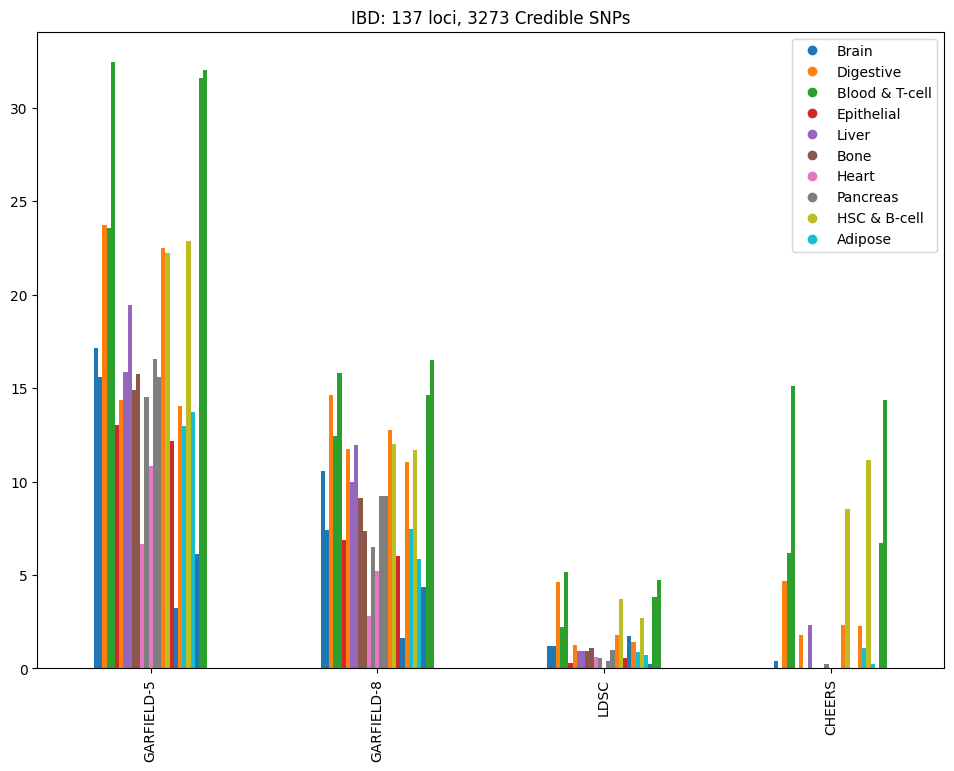

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

Results_df=pd.merge(GARFIELD_table_lower, GARFIELD_table_upper, on=['Annotation']).merge(LDSC_table, on=["Annotation"]).merge(CHEERS_table, on=["Annotation"])
Results_df=Results_df.drop(["Label_x", "Label_y"], axis=1)
Results_df.columns=["Annotation", "GARFIELD-5", "GARFIELD-8", "LDSC", "CHEERS"]
Results_df.index=Results_df["Annotation"]
Results_df=Results_df.drop(["Annotation"], axis=1)
Results_df=Results_df.transpose()
Results_df=-np.log10(Results_df)

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(Full_results['Celltype'].unique())))
#Colormap=pd.concat([Full_results['Celltype'].unique(), pd.DataFrame(colors)], axis=1)
#Colormap.columns=['Celltype', 'color']

Colormap={}

for i in range(0, len(Full_results['Celltype'].unique())):
    Colormap[Full_results['Celltype'].unique()[i]]=colors[i]

#Full_results['Color']=Full_results.apply(lambda x: Colormap.loc[Colormap['Celltype']==x['Celltype']].iloc[0]['color'])
#Full_results['Color']=Full_results.apply(lambda x: Colormap[x['Celltype']], axis=1)

DF_colormap={}
for i in range(0, len(GARFIELD_table_lower['Annotation'])):
    DF_colormap[(GARFIELD_table_lower['Annotation'][i])]=Colormap[epimap_meta.loc[epimap_meta['id'].str.contains(GARFIELD_table_lower['Annotation'][i])].iloc[0]['GROUP']]



#Results_df.index
Results_df.plot(use_index=True, kind='bar', stacked=False, title='IBD: 137 loci, 3273 Credible SNPs', figsize=(11.7, 8.27), color=DF_colormap, ax=ax)
#Results_df.columns=Results_df.loc['Annotation']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
ax.legend(markers, Colormap.keys(), numpoints=1)
#plt.yticks(range(0, len(Full_results['Annotation'])), Full_results['Annotation'], fontsize=3)
#to_plt_df=pd.DataFrame(["GARFIELD-5"])

In [84]:
-np.log10(Full_results['Pvalue'].min())

32.45235903650543

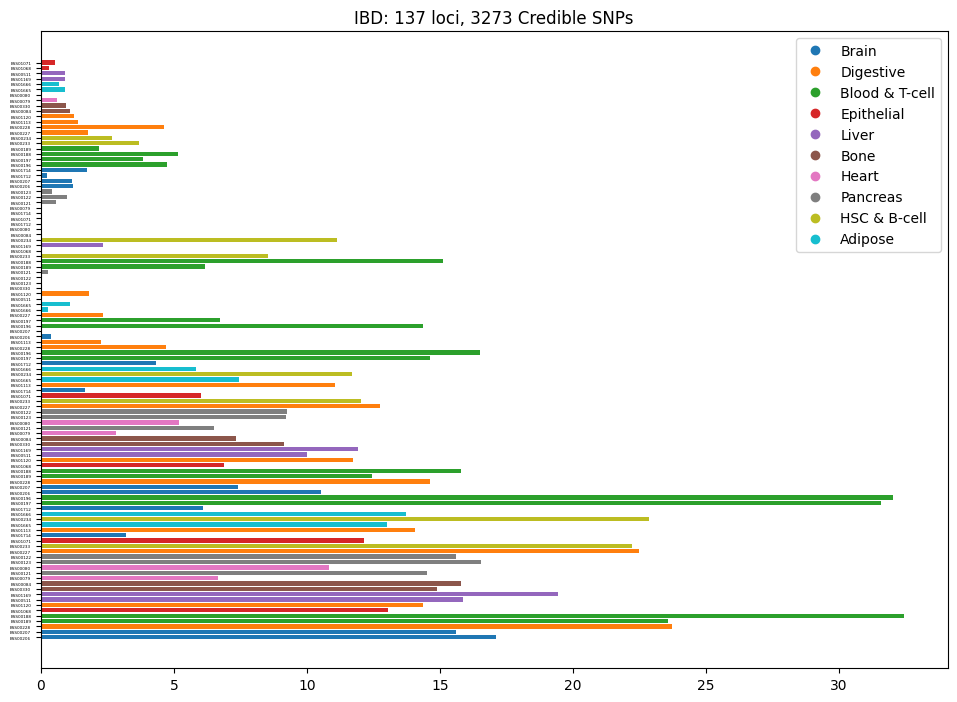

In [85]:
import matplotlib.pyplot as plt
plt.rcdefaults()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(Full_results['Celltype'].unique())))
#Colormap=pd.concat([Full_results['Celltype'].unique(), pd.DataFrame(colors)], axis=1)
#Colormap.columns=['Celltype', 'color']

Colormap={}

for i in range(0, len(Full_results['Celltype'].unique())):
    Colormap[Full_results['Celltype'].unique()[i]]=colors[i]

#Full_results['Color']=Full_results.apply(lambda x: Colormap.loc[Colormap['Celltype']==x['Celltype']].iloc[0]['color'])
Full_results['Color']=Full_results.apply(lambda x: Colormap[x['Celltype']], axis=1)

ax.barh(Full_results['Label'], -np.log10(Full_results['Pvalue']), align='center', color=Full_results['Color'])
ax.set_title('IBD: 137 loci, 3273 Credible SNPs')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
plt.legend(markers, Colormap.keys(), numpoints=1)
plt.yticks(range(0, len(Full_results['Annotation'])), Full_results['Annotation'], fontsize=3)
plt.show()

Text(0.5, 1.0, 'Garfield (p< 1e-8)')

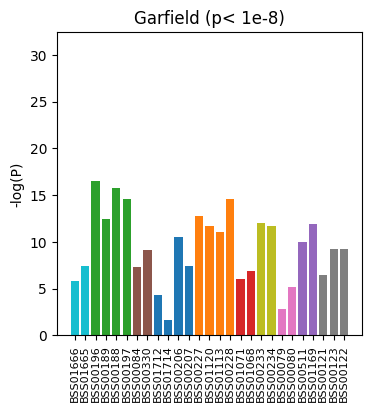

In [86]:
plt.rcdefaults()
fig.tight_layout(pad=0)
cm=1/2.54
a4_dims = (10*cm, 10*cm)
#a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Full_g5=Full_results.loc[Full_results['Label'].str.contains("GARFIELD-8")]
Full_g5=Full_g5.sort_values(["Celltype"])
ax.bar(Full_g5['Annotation'], -np.log10(Full_g5['Pvalue']), align='center', color=Full_g5['Color'])
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
#plt.legend(markers, Colormap.keys(), numpoints=1)
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, -np.log10(Full_results['Pvalue'].min()))
plt.ylabel("-log(P)")
ax.set_title('Garfield (p< 1e-8)')

Text(0.5, 1.0, 'Garfield (p< 1e-5)')

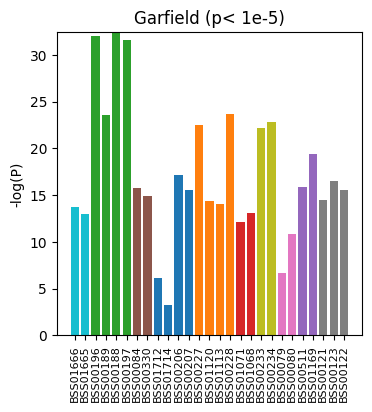

In [87]:
plt.rcdefaults()
fig.tight_layout(pad=0)
cm=1/2.54
a4_dims = (10*cm, 10*cm)
#a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Full_g5=Full_results.loc[Full_results['Label'].str.contains("GARFIELD-5")]
Full_g5=Full_g5.sort_values(["Celltype"])
plt.bar(Full_g5['Annotation'], -np.log10(Full_g5['Pvalue']), align='center', color=Full_g5['Color'])
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
#plt.legend(markers, Colormap.keys(), numpoints=1)
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, -np.log10(Full_results['Pvalue'].min()))
plt.ylabel("-log(P)")
ax.set_title('Garfield (p< 1e-5)')


Text(0.5, 1.0, 'LDSC')

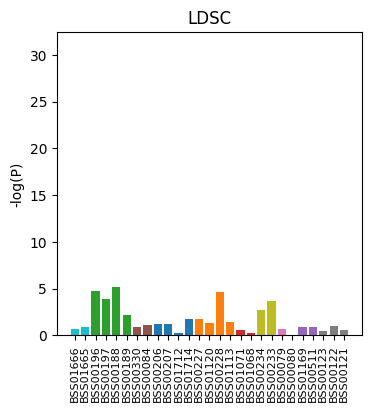

In [88]:
plt.rcdefaults()
fig.tight_layout(pad=0)
cm=1/2.54
a4_dims = (10*cm, 10*cm)
#a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Full_g5=Full_results.loc[Full_results['Label'].str.contains("LDSC")]
Full_g5=Full_g5.sort_values(["Celltype"])
ax.bar(Full_g5['Annotation'], -np.log10(Full_g5['Pvalue']), align='center', color=Full_g5['Color'])
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
#plt.legend(markers, Colormap.keys(), numpoints=1)
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, -np.log10(Full_results['Pvalue'].min()))
plt.ylabel("-log(P)")
ax.set_title('LDSC')

Text(0.5, 1.0, 'CHEERS')

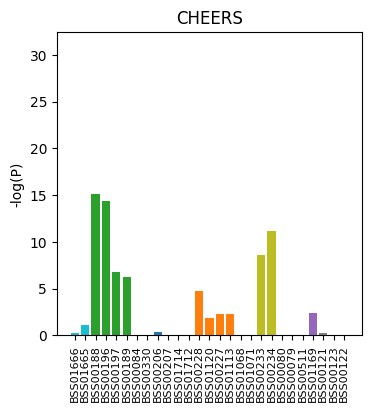

In [90]:
plt.rcdefaults()
fig.tight_layout(pad=0)
cm=1/2.54
a4_dims = (10*cm, 10*cm)
#a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Full_g5=Full_results.loc[Full_results['Label'].str.contains("CHEERS")]
Full_g5=Full_g5.sort_values(["Celltype"])
ax.bar(Full_g5['Annotation'], -np.log10(Full_g5['Pvalue']), align='center', color=Full_g5['Color'])
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
#plt.legend(markers, Colormap.keys(), numpoints=1)
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, -np.log10(Full_results['Pvalue'].min()))
plt.ylabel("-log(P)")
ax.set_title('CHEERS')

Text(0.5, 1.0, 'Tissue enrichments for IBD')

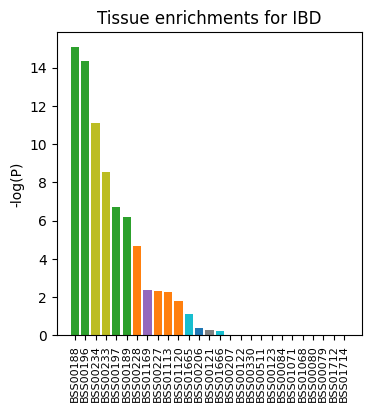

In [94]:
plt.rcdefaults()
fig.tight_layout(pad=0)
cm=1/2.54
a4_dims = (10*cm, 10*cm)
#a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Full_g5=Full_results.loc[Full_results['Label'].str.contains("CHEERS")]
Full_g5=Full_g5.sort_values(["Pvalue"])
ax.bar(Full_g5['Annotation'], -np.log10(Full_g5['Pvalue']), align='center', color=Full_g5['Color'])
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
#plt.legend(markers, Colormap.keys(), numpoints=1)
plt.xticks(rotation=90, fontsize=8)
#plt.ylim(0, -np.log10(Full_results['Pvalue'].min()))
plt.ylabel("-log(P)")
ax.set_title('Tissue enrichments for IBD')

Text(0.5, 1.0, 'Tissue enrichments for IBD')

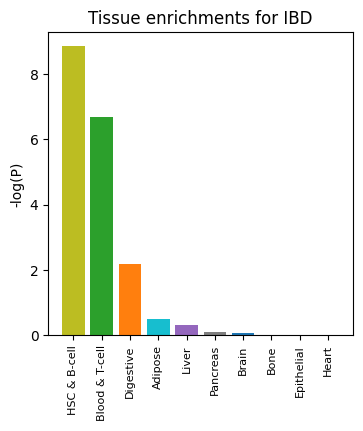

In [93]:
Aggregate_celltype_average=[]

for i in Full_g5["Celltype"].unique():
    Aggregate_celltype_average.append(np.mean(Full_g5.loc[Full_g5["Celltype"].str.contains(i)]["Pvalue"]))

Higher_level=pd.DataFrame(data={"Celltype":Full_g5["Celltype"].unique(), "Pvalue":Aggregate_celltype_average})
Higher_level['Color']=Higher_level.apply(lambda x: Colormap[x['Celltype']], axis=1)


plt.rcdefaults()
fig.tight_layout(pad=0)
cm=1/2.54
a4_dims = (10*cm, 10*cm)
#a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Full_g5=Full_results.loc[Full_results['Label'].str.contains("CHEERS")]
Full_g5=Full_g5.sort_values(["Pvalue"])
Higher_level=Higher_level.sort_values(["Pvalue"])
ax.bar(Higher_level['Celltype'], -np.log10(Higher_level['Pvalue']), align='center', color=Higher_level['Color'])
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
#plt.legend(markers, Colormap.keys(), numpoints=1)
plt.xticks(rotation=90, fontsize=8)
#plt.ylim(0, -np.log10(Full_results['Pvalue'].min()))
plt.ylabel("-log(P)")
ax.set_title('Tissue enrichments for IBD')

In [74]:
Full_g5

,Annotation,Pvalue,Label,Celltype,Color
20,BSS00234,6.108051e-07,BSS00234_CHEERS,HSC & B-cell,"[0.7372549019607844, 0.7411764705882353, 0.133..."
16,BSS00188,8.456018e-07,BSS00188_CHEERS,Blood & T-cell,"[0.17254901960784313, 0.6274509803921569, 0.17..."
4,BSS00196,8.851624e-07,BSS00196_CHEERS,Blood & T-cell,"[0.17254901960784313, 0.6274509803921569, 0.17..."
17,BSS00233,6.051401e-06,BSS00233_CHEERS,HSC & B-cell,"[0.7372549019607844, 0.7411764705882353, 0.133..."
5,BSS00197,2.703017e-03,BSS00197_CHEERS,Blood & T-cell,"[0.17254901960784313, 0.6274509803921569, 0.17..."
15,BSS00189,6.569943e-03,BSS00189_CHEERS,Blood & T-cell,"[0.17254901960784313, 0.6274509803921569, 0.17..."
11,BSS00330,2.139408e-02,BSS00330_CHEERS,Bone,"[0.5490196078431373, 0.33725490196078434, 0.29..."
2,BSS00206,4.535162e-02,BSS00206_CHEERS,Brain,"[0.12156862745098039, 0.4666666666666667, 0.70..."
0,BSS00228,5.023069e-02,BSS00228_CHEERS,Digestive,"[1.0, 0.4980392156862745, 0.054901960784313725..."
21,BSS00084,5.652330e-02,BSS00084_CHEERS,Bone,"[0.5490196078431373, 0.33725490196078434, 0.29..."


In [ ]:
import matplotlib.pyplot as plt
plt.rcdefaults()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(Full_results['Celltype'].unique())))
#Colormap=pd.concat([Full_results['Celltype'].unique(), pd.DataFrame(colors)], axis=1)
#Colormap.columns=['Celltype', 'color']

Colormap={}

for i in range(0, len(Full_results['Celltype'].unique())):
    Colormap[Full_results['Celltype'].unique()[i]]=colors[i]


#Full_results['Color']=Full_results.apply(lambda x: Colormap.loc[Colormap['Celltype']==x['Celltype']].iloc[0]['color'])
Full_results['Color']=Full_results.apply(lambda x: Colormap[x['Celltype']], axis=1)

barWidth=0.01
#r1=np.arange(len(Full_results.loc[Full_results['Label'].str.contains("GARFIELD-5")]['Pvalue'].reset_index(drop=True)))
# r2=[x+barWidth for x in r1]
# r3=[x+barWidth for x in r2]
# r4=[x+barWidth for x in r3]

# plt.bar(r1, -np.log10(Full_results.loc[Full_results['Label'].str.contains("GARFIELD-5")]['Pvalue'].reset_index(drop=True)), color=Full_results.loc[Full_results['Label'].str.contains("GARFIELD-5")]['Color'].reset_index(drop=True), label='GARFIELD-5')
# plt.bar(r2, -np.log10(Full_results.loc[Full_results['Label'].str.contains("GARFIELD-8")]['Pvalue'].reset_index(drop=True)), color=Full_results.loc[Full_results['Label'].str.contains("GARFIELD-8")]['Color'].reset_index(drop=True), label='GARFIELD-8')
# plt.bar(r3, -np.log10(Full_results.loc[Full_results['Label'].str.contains("CHEERS")]['Pvalue'].reset_index(drop=True)), color=Full_results.loc[Full_results['Label'].str.contains("CHEERS")]['Color'].reset_index(drop=True), label='CHEERS')
# plt.bar(r4, -np.log10(Full_results.loc[Full_results['Label'].str.contains("LDSC")]['Pvalue'].reset_index(drop=True)), color=Full_results.loc[Full_results['Label'].str.contains("LDSC")]['Color'].reset_index(drop=True), label='LDSC')

starting_x=[1, 2, 3, 4]

for sample in Full_results['Annotation'].unique():
    plt.bar(starting_x, -np.log10(Full_results.loc[Full_results['Annotation'].str.contains(sample)]['Pvalue'].reset_index(drop=True)), color=Full_results.loc[Full_results['Annotation'].str.contains(sample)]['Color'].reset_index(drop=True))
    starting_x=[x+barWidth for x in starting_x]
    
#ax.barh(Full_results['Label'], -np.log10(Full_results['Pvalue']), align='center', color=Full_results['Color'])
ax.set_title('IBD: 137 loci, 3273 Credible SNPs')

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in Colormap.values()]
plt.legend(markers, Colormap.keys(), numpoints=1)
#plt.yticks(range(0, len(Full_results['Annotation'])), Full_results['Annotation'], fontsize=3)
plt.show()

In [222]:
## Define "True positive cell types", calculate sensitivity based on:
##         1:  P-value thresholds for significance
##         2:  Rank each sample based on their P-value, top X percentile are "significant".
##         3:  Group by cell types, percent of enriched samples in each category.

###IBD_enriched=Full_g5.loc[Full_g5['Celltype'].str.contains('|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]))]

###
Full_CHEERS=Full_results.loc[Full_results['Label'].str.contains("CHEERS")]

## For example, IBD:
Disease_enriched=Full_CHEERS.loc[Full_CHEERS['Celltype'].str.contains('|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]))]['Annotation']

Res_by_P=Full_CHEERS.sort_values("Pvalue")
Current_enrichments=Res_by_P.loc[Res_by_P["Pvalue"] < 0.1]
#Current_enrichments
Current_TPR=len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Disease_enriched)]["Annotation"])/len(Current_enrichments["Annotation"])
#Current_FPR=len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(IBD_enriched)]["Annotation"])/

Current_TP=len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Disease_enriched)]["Annotation"])
Current_N=Res_by_P.loc[~Res_by_P['Annotation'].isin(Current_enrichments['Annotation'])]
Current_FN=len(Current_N.loc[Current_N['Annotation'].isin(Disease_enriched)]['Annotation'])
Current_TN=len(Current_N.loc[~Current_N['Annotation'].isin(Disease_enriched)]['Annotation'])

Current_accuracy=(Current_TP+Current_TN)/len(Res_by_P['Annotation'])
Current_recall=Current_TP/(Current_TP+Current_FN)
Current_precision=Current_TP/len(Current_enrichments["Annotation"])

Current_Fscore=(2*Current_recall*Current_precision)/(Current_recall+Current_precision)

print("CHEERS enrichment metrics for IBD: accuracy: "+str(Current_accuracy)+" , recall: "+str(Current_recall)+" , precision: "+str(Current_precision)+" , F-score:"+str(Current_Fscore))

len(Full_CHEERS['Annotation'])


CHEERS enrichment metrics for IBD: accuracy: 0.9259259259259259 , recall: 1.0 , precision: 0.8333333333333334 , F-score:0.9090909090909091


27

In [315]:
def Performance_metrics(method, trait, expected_enrichments, P_threshold, top_ranks):
    Res_method=Full_results.loc[Full_results['Label'].str.contains(method)]
    # expected_enrichments = '|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"])
    ## For example, IBD:
    #Disease_enriched=Full_CHEERS.loc[Full_CHEERS['Celltype'].str.contains('|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]))]['Annotation']
    Trait_enriched=Res_method.loc[Res_method['Celltype'].str.contains(expected_enrichments)]['Annotation'] 
    Res_by_P=Res_method.sort_values("Pvalue")
    Current_enrichments=Res_by_P
    if top_ranks>0:
        Current_enrichments=Res_by_P.head(top_ranks)
    Current_enrichments=Current_enrichments.loc[Current_enrichments["Pvalue"] < P_threshold]
    #Current_enrichments
    #Current_TPR=len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])/len(Current_enrichments["Annotation"])
    #Current_FPR=len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(IBD_enriched)]["Annotation"])/
    Current_P=len(Current_enrichments["Annotation"])
    Current_TP=len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
    Current_FP=len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
    Current_N=Res_by_P.loc[~Res_by_P['Annotation'].isin(Current_enrichments['Annotation'])]
    Current_FN=len(Current_N.loc[Current_N['Annotation'].isin(Trait_enriched)]['Annotation'])
    Current_TN=len(Current_N.loc[~Current_N['Annotation'].isin(Trait_enriched)]['Annotation'])

    # Jeremy's power calculation suggestion:
    Current_TP_logP=-np.log10(Current_enrichments['Pvalue'])
    Current_N_logP=-np.log10(Current_N['Pvalue'])

    Power_estimate=0
    if (sum(Current_TP_logP)+sum(Current_N_logP) > 0):
        Power_estimate=sum(Current_TP_logP)/(sum(Current_TP_logP)+sum(Current_N_logP))

    Current_accuracy=(Current_TP+Current_TN)/len(Res_by_P['Annotation'])
    Current_recall=Current_TP/(Current_TP+Current_FN)

    # For ROC:
    Current_TPR=0
    if(Current_P>0):
        Current_TPR=Current_TP/Current_P
    Current_FPR=0
    if(Current_FP+Current_TN > 0):
        Current_FPR=Current_FP/(Current_FP+Current_TN)

    # For F-score:

    Current_precision=0
    if(len(Current_enrichments['Annotation']) > 0):
        Current_precision=Current_TP/len(Current_enrichments["Annotation"])

    Current_Fscore=0
    if(Current_recall > 0 and Current_precision > 0):
        Current_Fscore=(2*Current_recall*Current_precision)/(Current_recall+Current_precision)

    #print(str(method)+" enrichment metrics for "+str(trait)+" accuracy: "+str(Current_accuracy)+" , recall: "+str(Current_recall)+" , precision: "+str(Current_precision)+" , F-score:"+str(Current_Fscore))
    return(Current_accuracy, Current_recall, Current_precision, Current_Fscore, Power_estimate, Current_TPR, Current_FPR)

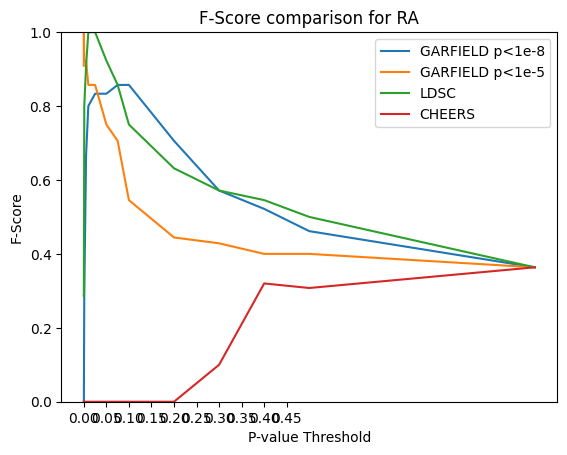

In [290]:
def Plot_metrics_by_P(trait, expected_enrichments):
    P_threshold_list=[1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001]
    G8_metrics=[]
    G5_metrics=[]
    LDSC_metrics=[]
    CHEERS_metrics=[]

    for i in range(0, len(P_threshold_list)):
        G8_metrics.append(Performance_metrics("GARFIELD-8", trait, expected_enrichments, P_threshold_list[i], 0)[3])
        G5_metrics.append(Performance_metrics("GARFIELD-5", trait, expected_enrichments, P_threshold_list[i], 0)[3])
        LDSC_metrics.append(Performance_metrics("LDSC", trait, expected_enrichments, P_threshold_list[i], 0)[3])
        CHEERS_metrics.append(Performance_metrics("CHEERS", trait, expected_enrichments,  P_threshold_list[i], 0)[3])

    Metrics_df=pd.DataFrame({'P-Value':P_threshold_list, 'G8_Metrics': G8_metrics, 'G5_Metrics':G5_metrics, 'LDSC_Metrics':LDSC_metrics, 'CHEERS_Metrics':CHEERS_metrics})
    plt.xlabel('P-value Threshold')
    # Set the y axis label of the current axis.
    plt.ylabel('F-Score')
    # Set a title of the current axes.
    plt.title('F-Score comparison for '+trait)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 0.5, 0.05))
    plt.plot(Metrics_df['P-Value'], Metrics_df['G8_Metrics'], label="GARFIELD p<1e-8")
    plt.plot(Metrics_df['P-Value'], Metrics_df['G5_Metrics'], label="GARFIELD p<1e-5")
    plt.plot(Metrics_df['P-Value'], Metrics_df['LDSC_Metrics'], label="LDSC")
    plt.plot(Metrics_df['P-Value'], Metrics_df['CHEERS_Metrics'], label="CHEERS")
    plt.legend()
    plt.show()

#Plot_metrics_by_P("T2D", '|'.join(["Blood & T-cell", "Pancreas", "Adipose"]))
#Plot_metrics_by_P("T1D", '|'.join(["Blood & T-cell", "Pancreas", "HSC & B-cell"]))
#Plot_metrics_by_P("Atopic dermatitis", '|'.join(["Blood & T-cell", "HSC & B-cell"]))
#Plot_metrics_by_P("Alzheimers", '|'.join(["Brain", "HSC & B-cell"]))
Plot_metrics_by_P("RA", '|'.join(["Blood & T-cell", "HSC & B-cell"]))

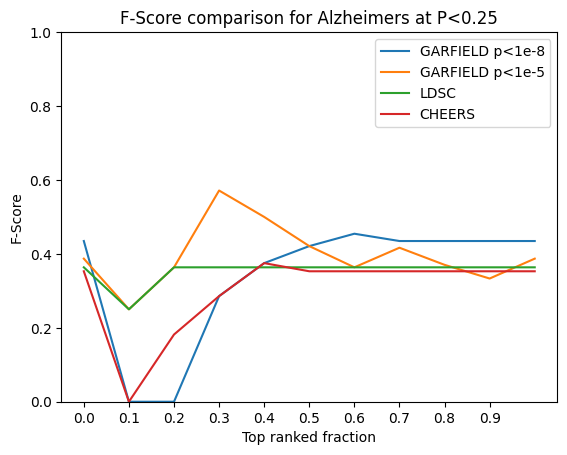

In [278]:
import math
def Plot_metrics_by_rank(trait, expected_enrichments, P_threshold):
    #P_threshold_list=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001]
    Sample_size=27
    Top_rankings_list=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
    G8_metrics=[]
    G5_metrics=[]
    LDSC_metrics=[]
    CHEERS_metrics=[]

    for i in range(0, len(Top_rankings_list)):
        G8_metrics.append(Performance_metrics("GARFIELD-8", trait, expected_enrichments, P_threshold, math.floor(Top_rankings_list[i]*Sample_size))[3])
        G5_metrics.append(Performance_metrics("GARFIELD-5", trait, expected_enrichments, P_threshold, math.floor(Top_rankings_list[i]*Sample_size))[3])
        LDSC_metrics.append(Performance_metrics("LDSC", trait, expected_enrichments, P_threshold, math.floor(Top_rankings_list[i]*Sample_size))[3])
        CHEERS_metrics.append(Performance_metrics("CHEERS", trait, expected_enrichments,  P_threshold, math.floor(Top_rankings_list[i]*Sample_size))[3])

    Metrics_df=pd.DataFrame({'P-Value':Top_rankings_list, 'G8_Metrics': G8_metrics, 'G5_Metrics':G5_metrics, 'LDSC_Metrics':LDSC_metrics, 'CHEERS_Metrics':CHEERS_metrics})
    plt.xlabel('Top ranked fraction')
    # Set the y axis label of the current axis.
    plt.ylabel('F-Score')
    # Set a title of the current axes.
    plt.title('F-Score comparison for '+trait+" at P<"+str(P_threshold))
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1, 0.1))
    plt.plot(Metrics_df['P-Value'], Metrics_df['G8_Metrics'], label="GARFIELD p<1e-8")
    plt.plot(Metrics_df['P-Value'], Metrics_df['G5_Metrics'], label="GARFIELD p<1e-5")
    plt.plot(Metrics_df['P-Value'], Metrics_df['LDSC_Metrics'], label="LDSC")
    plt.plot(Metrics_df['P-Value'], Metrics_df['CHEERS_Metrics'], label="CHEERS")
    plt.legend()
    plt.show()

#Plot_metrics_by_rank("T2D", '|'.join(["Blood & T-cell", "Pancreas", "Adipose"]), 0.1)
#Plot_metrics_by_rank("T1D", '|'.join(["Blood & T-cell", "Pancreas", "HSC & B-cell"]), 0.)
Plot_metrics_by_rank("Alzheimers", '|'.join(["Brain", "HSC & B-cell"]), 0.25)

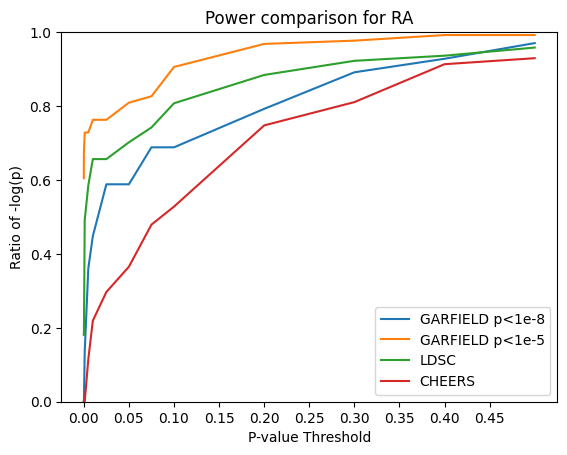

In [291]:
def Plot_power_by_P(trait, expected_enrichments):
    P_threshold_list=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001]
    G8_metrics=[]
    G5_metrics=[]
    LDSC_metrics=[]
    CHEERS_metrics=[]

    for i in range(0, len(P_threshold_list)):
        G8_metrics.append(Performance_metrics("GARFIELD-8", trait, expected_enrichments, P_threshold_list[i], 0)[4])
        G5_metrics.append(Performance_metrics("GARFIELD-5", trait, expected_enrichments, P_threshold_list[i], 0)[4])
        LDSC_metrics.append(Performance_metrics("LDSC", trait, expected_enrichments, P_threshold_list[i], 0)[4])
        CHEERS_metrics.append(Performance_metrics("CHEERS", trait, expected_enrichments,  P_threshold_list[i], 0)[4])

    Metrics_df=pd.DataFrame({'P-Value':P_threshold_list, 'G8_Metrics': G8_metrics, 'G5_Metrics':G5_metrics, 'LDSC_Metrics':LDSC_metrics, 'CHEERS_Metrics':CHEERS_metrics})
    plt.xlabel('P-value Threshold')
    # Set the y axis label of the current axis.
    plt.ylabel('Ratio of -log(p)')
    # Set a title of the current axes.
    plt.title('Power comparison for '+trait)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 0.5, 0.05))
    plt.plot(Metrics_df['P-Value'], Metrics_df['G8_Metrics'], label="GARFIELD p<1e-8")
    plt.plot(Metrics_df['P-Value'], Metrics_df['G5_Metrics'], label="GARFIELD p<1e-5")
    plt.plot(Metrics_df['P-Value'], Metrics_df['LDSC_Metrics'], label="LDSC")
    plt.plot(Metrics_df['P-Value'], Metrics_df['CHEERS_Metrics'], label="CHEERS")
    plt.legend()
    plt.show()

Plot_power_by_P("RA", '|'.join(["Blood & T-cell", "HSC & B-cell"]))


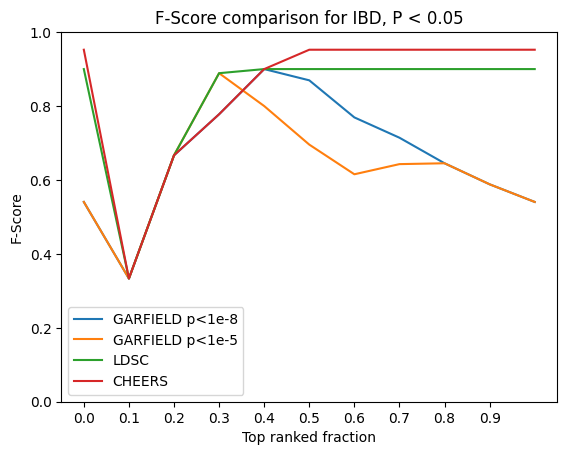

In [229]:
#P_threshold_list=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001]
import math
Sample_size=27
Top_rankings_list=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

G8_metrics=[]
G5_metrics=[]
LDSC_metrics=[]
CHEERS_metrics=[]


for i in range(0, len(Top_rankings_list)):
    G8_metrics.append(Performance_metrics("GARFIELD-8", "IBD", '|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]), 0.05, math.floor(Top_rankings_list[i]*Sample_size))[3])
    G5_metrics.append(Performance_metrics("GARFIELD-5", "IBD", '|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]), 0.05, math.floor(Top_rankings_list[i]*Sample_size))[3])
    LDSC_metrics.append(Performance_metrics("LDSC", "IBD", '|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]), 0.05, math.floor(Top_rankings_list[i]*Sample_size))[3])
    CHEERS_metrics.append(Performance_metrics("CHEERS", "IBD", '|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]), 0.05, math.floor(Top_rankings_list[i]*Sample_size))[3])


Metrics_df=pd.DataFrame({'P-Value':Top_rankings_list, 'G8_Metrics': G8_metrics, 'G5_Metrics':G5_metrics, 'LDSC_Metrics':LDSC_metrics, 'CHEERS_Metrics':CHEERS_metrics})

plt.xlabel('Top ranked fraction')
# Set the y axis label of the current axis.
plt.ylabel('F-Score')
# Set a title of the current axes.
plt.title('F-Score comparison for IBD, P < 0.05')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1, 0.1))
plt.plot(Metrics_df['P-Value'], Metrics_df['G8_Metrics'], label="GARFIELD p<1e-8")
plt.plot(Metrics_df['P-Value'], Metrics_df['G5_Metrics'], label="GARFIELD p<1e-5")
plt.plot(Metrics_df['P-Value'], Metrics_df['LDSC_Metrics'], label="LDSC")
plt.plot(Metrics_df['P-Value'], Metrics_df['CHEERS_Metrics'], label="CHEERS")
plt.legend()
plt.show()

In [227]:
Top_rankings_list

array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ])

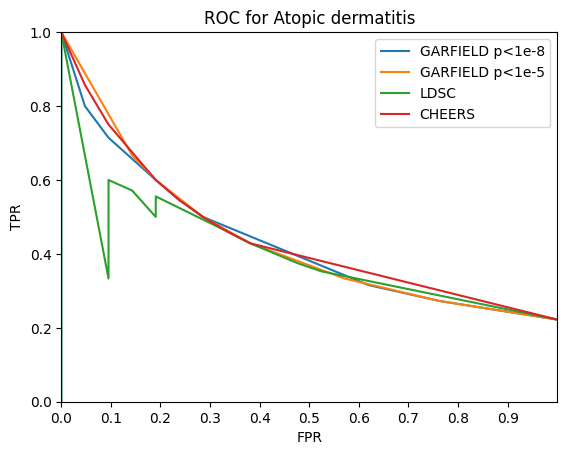

In [316]:
def Plot_ROC_by_P(trait, expected_enrichments):
    P_threshold_list=[1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001]

    G8_metrics=[]
    G5_metrics=[]
    LDSC_metrics=[]
    CHEERS_metrics=[]

    G8_FPR=[]
    G5_FPR=[]
    LDSC_FPR=[]
    CHEERS_FPR=[]

    for i in range(0, len(P_threshold_list)):
        G8_metrics.append(Performance_metrics("GARFIELD-8", trait, expected_enrichments, P_threshold_list[i], 0)[5])
        G5_metrics.append(Performance_metrics("GARFIELD-5", trait, expected_enrichments, P_threshold_list[i], 0)[5])
        LDSC_metrics.append(Performance_metrics("LDSC", trait, expected_enrichments, P_threshold_list[i], 0)[5])
        
        CHEERS_metrics.append(Performance_metrics("CHEERS", trait, expected_enrichments,  P_threshold_list[i], 0)[5])
        G8_FPR.append(Performance_metrics("GARFIELD-8", trait, expected_enrichments, P_threshold_list[i], 0)[6])
        G5_FPR.append(Performance_metrics("GARFIELD-5", trait, expected_enrichments, P_threshold_list[i], 0)[6])
        LDSC_FPR.append(Performance_metrics("LDSC", trait, expected_enrichments, P_threshold_list[i], 0)[6])
        CHEERS_FPR.append(Performance_metrics("CHEERS", trait, expected_enrichments,  P_threshold_list[i], 0)[6])

    Metrics_df=pd.DataFrame({'P-Value':P_threshold_list, 'G8_Metrics': G8_metrics, 'G5_Metrics':G5_metrics, 'LDSC_Metrics':LDSC_metrics, 'CHEERS_Metrics':CHEERS_metrics})
    FPR_df=pd.DataFrame({'P-Value':P_threshold_list, 'G8_Metrics': G8_FPR, 'G5_Metrics':G5_FPR, 'LDSC_Metrics':LDSC_FPR, 'CHEERS_Metrics':CHEERS_FPR})
    plt.xlabel('FPR')
    # Set the y axis label of the current axis.
    plt.ylabel('TPR')
    # Set a title of the current axes.
    plt.title('ROC for '+trait)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1, 0.1))
    plt.plot(FPR_df['G8_Metrics'], Metrics_df['G8_Metrics'], label="GARFIELD p<1e-8")
    plt.plot(FPR_df['G5_Metrics'], Metrics_df['G5_Metrics'], label="GARFIELD p<1e-5")
    plt.plot(FPR_df['LDSC_Metrics'], Metrics_df['LDSC_Metrics'], label="LDSC")
    plt.plot(FPR_df['CHEERS_Metrics'], Metrics_df['CHEERS_Metrics'], label="CHEERS")
    plt.legend()
    plt.show()

#Plot_metrics_by_P("T2D", '|'.join(["Blood & T-cell", "Pancreas", "Adipose"]))
#Plot_metrics_by_P("T1D", '|'.join(["Blood & T-cell", "Pancreas", "HSC & B-cell"]))
Plot_ROC_by_P("Atopic dermatitis", '|'.join(["Blood & T-cell", "HSC & B-cell"]))
#Plot_metrics_by_P("Alzheimers", '|'.join(["Brain", "HSC & B-cell"]))
#Plot_ROC_by_P("RA", '|'.join(["Blood & T-cell", "HSC & B-cell"]))
#Plot_ROC_by_P("IBD", '|'.join(["Blood & T-cell", "HSC & B-cell", "Digestive"]))

In [308]:
Performance_metrics("CHEERS", "IBD", '|'.join(["Blood & T-cell", "HSC & B-cell", "Digestive"]), 0.1, 0)

(0.9259259259259259,
 1.0,
 0.8333333333333334,
 0.9090909090909091,
 0.9874113815310662,
 0.8333333333333334,
 0.11764705882352941)

In [ ]:
Full_g8=Full_results.loc[Full_results['Label'].str.contains("GARFIELD-8")]

Current_enrichments=Full_g8.sort_values("Pvalue")
Current_enrichments=Current_enrichments.loc[Current_enrichments["Pvalue"] < 0.1]
Current_enrichments

Full_g5=Full_results.loc[Full_results['Label'].str.contains("GARFIELD-5")] 

Current_enrichments=Full_g5.sort_values("Pvalue")
Current_enrichments=Current_enrichments.loc[Current_enrichments["Pvalue"] < 0.1]
Current_enrichments

Full_LDSC=Full_results.loc[Full_results['Label'].str.contains("LDSC")]

Current_enrichments=Full_LDSC.sort_values("Pvalue")
Current_enrichments=Current_enrichments.loc[Current_enrichments["Pvalue"] < 0.1]
Current_enrichments

#T2D_enriched=Full_g5.loc[]
#Current_TPR


In [ ]:
from collections import OrderedDict

P_threshold_list=[1, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001]

Expected_enrichment_d={'Disease':["Alzheimers",	"Atopic",		"IBD", "RA",		"T1D",		"T2D"], 
    'Celltype':['|'.join(["Brain", "HSC & B-cell"]), '|'.join(["Blood & T-cell", "HSC & B-cell"]), '|'.join(["Blood & T-cell", "HSC & B-cell", "Digestive"]), '|'.join(["Blood & T-cell", "HSC & B-cell"]), '|'.join(["Blood & T-cell", "Pancreas", "HSC & B-cell"]),  '|'.join(["Blood & T-cell", "Pancreas", "Adipose"])]}
Expected_enrichment_df=pd.DataFrame(data=Expected_enrichment_d)
Expected_enrichment_df

LDSC_results_dir="/Users/xg1/Downloads/ldsc/results/"
GARFIELD_results_dir="/Users/xg1/Downloads/garfield-data/output_EP/"
CHEERS_results_dir="/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/"

#Disease="Atopic"
All_diseases=["Alzheimers",	"Atopic",	"IBD",		"IBD_10",		"IBD_16",		"IBD_76",		"RA",		"T1D",		"T2D",		"T2D_131",		"T2D_29",		"T2D_46"]

CHEERS_metrics_table=pd.DataFrame(data={"P_thresh": P_threshold_list, "P": 0, "TP":0, "N":0, "FN":0})

for Disease in All_diseases:
        CHEERS_table=pd.read_csv(CHEERS_results_dir+Disease+"_disease_enrichment_pValues.txt", sep="\t", names=["Annotation", "Pvalue"])
        CHEERS_table['Celltype']=CHEERS_table.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)
        Expected_cells=Expected_enrichment_df.loc[Expected_enrichment_df['Disease'].str.contains(Disease.split("_")[0])]["Celltype"]
        Results_by_p=CHEERS_table.sort_values("Pvalue")
        Trait_enriched=Results_by_p.loc[Results_by_p['Celltype'].str.contains(Expected_cells)]['Annotation'] 
    for P_thresh in P_threshold_list:
        Current_enrichments=Results_by_p.loc[Results_by_p["Pvalue"] < P_thresh]
        Current_Ns=Results_by_p.loc[~Results_by_p['Annotation'].isin(Current_enrichments['Annotation'])]
        CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["P"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["P"]+len(Current_enrichments["Annotation"])
        CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["TP"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["TP"]+len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
        CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["N"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["N"]+len(Results_by_p.loc[~Results_by_p['Annotation'].isin(Current_enrichments['Annotation'])]['Annotation'])
        CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["FN"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh]["FN"]+len(Current_N.loc[Current_N['Annotation'].isin(Trait_enriched)]['Annotation'])




    #CHEERS_table['Label']=CHEERS_table['Annotation']+"_CHEERS"

LDSC_table=pd.read_csv(LDSC_results_dir+Disease+"/Epimap_EP.results", sep="\t", header=0).loc[:, ["Category", "Enrichment_p"]]
#LDSC_table=pd.read_csv(LDSC_results_dir+Disease+"/"+Disease+".results", sep="\t", header=0).loc[:, ["Category", "Enrichment_p"]]

LDSC_table=LDSC_table.rename(columns={"Category":"Category", "Enrichment_p":"Pvalue"})
LDSC_table['Annotation']=LDSC_table.apply(lambda x: x['Category'].split("L2")[0], axis=1)
LDSC_table=LDSC_table.loc[LDSC_table['Annotation'].isin(epimap_meta['id'])]

LDSC_table['Label']=LDSC_table['Annotation']+"_LDSC"


LDSC_table=LDSC_table.drop(columns=['Category'], axis=1)
#GARFIELD_table=pd.read_csv(GARFIELD_results_dir+Disease+"/garfield.test."+Disease+".out", sep=" ", header=0).loc[:, ["Annotation", "Pvalue", "Celltype", "Tissue", "PThresh"]]

GARFIELD_table=pd.read_csv(GARFIELD_results_dir+Disease+"/garfield.test."+Disease+".out", sep=" ", header=0).loc[:, ["Annotation", "Pvalue", "PThresh"]]


GARFIELD_table_lower=GARFIELD_table.loc[GARFIELD_table['PThresh'] == 1.000000e-05].drop(columns=["PThresh"], axis=1).reset_index(drop=True)
GARFIELD_table_upper=GARFIELD_table.loc[GARFIELD_table['PThresh'] == 1.000000e-08].drop(columns=["PThresh"], axis=1).reset_index(drop=True)

GARFIELD_table_lower['Label']=GARFIELD_table_lower['Annotation']+"_GARFIELD-5"
GARFIELD_table_upper['Label']=GARFIELD_table_upper['Annotation']+"_GARFIELD-8"

Full_results=pd.concat([GARFIELD_table_lower, GARFIELD_table_upper,CHEERS_table, LDSC_table])
Full_results['Celltype']=Full_results.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)

In [3]:
def Performance_metrics(method, trait, expected_enrichments, P_threshold, top_ranks):
    Res_method=Full_results.loc[Full_results['Label'].str.contains(method)]
    # expected_enrichments = '|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"])
    ## For example, IBD:
    #Disease_enriched=Full_CHEERS.loc[Full_CHEERS['Celltype'].str.contains('|'.join(["Blood & T-cell", "Digestive", "HSC & B-cell"]))]['Annotation']
    Trait_enriched=Res_method.loc[Res_method['Celltype'].str.contains(expected_enrichments)]['Annotation'] 
    Res_by_P=Res_method.sort_values("Pvalue")
    Current_enrichments=Res_by_P
    if top_ranks>0:
        Current_enrichments=Res_by_P.head(top_ranks)
    Current_enrichments=Current_enrichments.loc[Current_enrichments["Pvalue"] < P_threshold]
    #Current_enrichments
    #Current_TPR=len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])/len(Current_enrichments["Annotation"])
    #Current_FPR=len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(IBD_enriched)]["Annotation"])/
    Current_P=len(Current_enrichments["Annotation"])
    Current_TP=len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
    Current_FP=len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
    Current_N=Res_by_P.loc[~Res_by_P['Annotation'].isin(Current_enrichments['Annotation'])]
    Current_FN=len(Current_N.loc[Current_N['Annotation'].isin(Trait_enriched)]['Annotation'])
    Current_TN=len(Current_N.loc[~Current_N['Annotation'].isin(Trait_enriched)]['Annotation'])
#Plot_metrics_by_P("T2D", '|'.join(["Blood & T-cell", "Pancreas", "Adipose"]))
#Plot_metrics_by_P("T1D", '|'.join(["Blood & T-cell", "Pancreas", "HSC & B-cell"]))
#Plot_ROC_by_P("Atopic dermatitis", '|'.join(["Blood & T-cell", "HSC & B-cell"]))
#Plot_metrics_by_P("Alzheimers", '|'.join(["Brain", "HSC & B-cell"]))
#Plot_ROC_by_P("RA", '|'.join(["Blood & T-cell", "HSC & B-cell"]))
#Plot_ROC_by_P("IBD", '|'.join(["Blood & T-cell", "HSC & B-cell", "Digestive"]))

,Disease,Celltype
0,Alzheimers,Brain|HSC & B-cell
1,Atopic,Blood & T-cell|HSC & B-cell
2,IBD,Blood & T-cell|HSC & B-cell|Digestive
3,RA,Blood & T-cell|HSC & B-cell
4,T1D,Blood & T-cell|Pancreas|HSC & B-cell
5,T2D,Blood & T-cell|Pancreas|Adipose


In [5]:
CHEERS_metrics_table=pd.DataFrame(data={"P_thresh": P_threshold_list, "P": 0, "TP":0, "N":0, "FN":0})
CHEERS_metrics_table


,P_thresh,P,TP,N,FN
0,1.00000,0,0,0,0
1,0.30000,0,0,0,0
2,0.20000,0,0,0,0
3,0.10000,0,0,0,0
4,0.07500,0,0,0,0
5,0.05000,0,0,0,0
6,0.02500,0,0,0,0
7,0.01000,0,0,0,0
8,0.00500,0,0,0,0
9,0.00100,0,0,0,0


In [54]:
P_threshold_list=[1, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001, 0.00001, 0]

Expected_enrichment_d={'Disease':["Alzheimers",	"Atopic",		"IBD", "RA",		"T1D",		"T2D"], 
    'Celltype':['|'.join(["Brain", "HSC & B-cell"]), '|'.join(["Blood & T-cell", "HSC & B-cell"]), '|'.join(["Blood & T-cell", "HSC & B-cell", "Digestive"]), '|'.join(["Blood & T-cell", "HSC & B-cell"]), '|'.join(["Blood & T-cell", "Pancreas", "HSC & B-cell"]),  '|'.join(["Blood & T-cell", "Pancreas", "Adipose"])]}
Expected_enrichment_df=pd.DataFrame(data=Expected_enrichment_d)
Expected_enrichment_df

LDSC_results_dir="/Users/xg1/Downloads/ldsc/results/"
GARFIELD_results_dir="/Users/xg1/Downloads/garfield-data/output_EP/"
CHEERS_results_dir="/Users/xg1/Downloads/CHEERS/H3K27ac_epimap_comparison_results_09082021/"

#Disease="Atopic"
All_diseases=["Alzheimers",	"Atopic",	"IBD",		"IBD_10",		"IBD_16",		"IBD_76",		"RA",		"T1D",		"T2D",		"T2D_131",		"T2D_29",		"T2D_46"]

CHEERS_metrics_table=pd.DataFrame(data={"P_thresh": P_threshold_list, "P": 0, "TP":0, "N":0, "FP":0, "FN":0, "TN":0})

# def Make_confusion_matrix(metrics_table, Current_PP, Current_PN, threshold):
#             metrics_table.loc[metrics_table["P_thresh"]==threshold, "P"]=metrics_table.loc[metrics_table["P_thresh"]==threshold, "P"]+len(Trait_enriched)
#             metrics_table.loc[metrics_table["P_thresh"]==threshold, "TP"]=metrics_table.loc[metrics_table["P_thresh"]==threshold, "TP"]+len(Current_PP.loc[Current_PP['Annotation'].isin(Trait_enriched)]["Annotation"])
#             metrics_table.loc[metrics_table["P_thresh"]==threshold, "N"]=metrics_table.loc[metrics_table["P_thresh"]==threshold, "N"]+(len(Results_by_p['Annotation'])-len(Trait_enriched))
#             metrics_table.loc[metrics_table["P_thresh"]==threshold, "FP"]=metrics_table.loc[metrics_table["P_thresh"]==threshold, "FP"]+len(Current_PP.loc[~Current_PP['Annotation'].isin(Trait_enriched)]["Annotation"])
#             metrics_table.loc[metrics_table["P_thresh"]==threshold, "FN"]=metrics_table.loc[metrics_table["P_thresh"]==threshold, "FN"]+len(Current_PN.loc[Current_PN["Annotation"].isin(Trait_enriched)]["Annotation"])
#             metrics_table.loc[metrics_table["P_thresh"]==threshold, "TN"]=metrics_table.loc[metrics_table["P_thresh"]==threshold, "TN"]+len(Current_PN.loc[~Current_PN["Annotation"].isin(Trait_enriched)]["Annotation"])
#             return(metrics_table)

for Disease in All_diseases:
        CHEERS_table=pd.read_csv(CHEERS_results_dir+Disease+"_disease_enrichment_pValues.txt", sep="\t", names=["Annotation", "Pvalue"])
        CHEERS_table['Celltype']=CHEERS_table.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)
        Expected_cells=Expected_enrichment_df.loc[Expected_enrichment_df['Disease'].str.contains(Disease.split("_")[0])]["Celltype"].reset_index(drop=True)[0]
        Results_by_p=CHEERS_table.sort_values("Pvalue")
        Trait_enriched=Results_by_p.loc[Results_by_p['Celltype'].str.contains(Expected_cells)]['Annotation'] 
        for P_thresh in P_threshold_list:
            Current_enrichments=Results_by_p.loc[Results_by_p["Pvalue"] < P_thresh]
            Current_Ns=Results_by_p.loc[~Results_by_p['Annotation'].isin(Current_enrichments['Annotation'])]

            #CHEERS_metrics_table=Make_confusion_matrix(CHEERS_metrics_table, Current_PP, Current_PN, threshold)

            CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "P"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "P"]+len(Trait_enriched)
            CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "TP"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "TP"]+len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "N"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "N"]+(len(Results_by_p['Annotation'])-len(Trait_enriched))
            CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "FP"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "FP"]+len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "FN"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "FN"]+len(Current_Ns.loc[Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])
            CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "TN"]=CHEERS_metrics_table.loc[CHEERS_metrics_table["P_thresh"]==P_thresh, "TN"]+len(Current_Ns.loc[~Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])

CHEERS_metrics_table['F_score']=CHEERS_metrics_table.apply(lambda x: 2*x['TP']/(2*x['TP']+x['FP']+x['FN']), axis=1)
CHEERS_metrics_table
###########################################################################################################################################################################################################################################################################################################################
LDSC_metrics_table=pd.DataFrame(data={"P_thresh": P_threshold_list, "P": 0, "TP":0, "N":0, "FP":0, "FN":0, "TN":0})

for Disease in All_diseases:
        LDSC_table=pd.read_csv(LDSC_results_dir+Disease+"/Epimap_EP.results", sep="\t", header=0).loc[:, ["Category", "Enrichment_p"]]
        LDSC_table=LDSC_table.rename(columns={"Category":"Category", "Enrichment_p":"Pvalue"})
        LDSC_table['Annotation']=LDSC_table.apply(lambda x: x['Category'].split("L2")[0], axis=1)
        LDSC_table=LDSC_table.loc[LDSC_table['Annotation'].isin(epimap_meta['id'])]
        LDSC_table['Celltype']=LDSC_table.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)
        LDSC_table=LDSC_table.drop(columns=['Category'], axis=1)

        Expected_cells=Expected_enrichment_df.loc[Expected_enrichment_df['Disease'].str.contains(Disease.split("_")[0])]["Celltype"].reset_index(drop=True)[0]
        Results_by_p=LDSC_table.sort_values("Pvalue")
        Trait_enriched=Results_by_p.loc[Results_by_p['Celltype'].str.contains(Expected_cells)]['Annotation'] 
        for P_thresh in P_threshold_list:
            Current_enrichments=Results_by_p.loc[Results_by_p["Pvalue"] < P_thresh]
            Current_Ns=Results_by_p.loc[~Results_by_p['Annotation'].isin(Current_enrichments['Annotation'])]

            LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "P"]=LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "P"]+len(Trait_enriched)
            LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "TP"]=LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "TP"]+len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "N"]=LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "N"]+(len(Results_by_p['Annotation'])-len(Trait_enriched))
            LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "FP"]=LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "FP"]+len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "FN"]=LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "FN"]+len(Current_Ns.loc[Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])
            LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "TN"]=LDSC_metrics_table.loc[LDSC_metrics_table["P_thresh"]==P_thresh, "TN"]+len(Current_Ns.loc[~Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])

LDSC_metrics_table['F_score']=LDSC_metrics_table.apply(lambda x: 2*x['TP']/(2*x['TP']+x['FP']+x['FN']),  axis=1)
LDSC_metrics_table

###########################################################################################################################################################################################################################################################################################################################

G5_metrics_table=pd.DataFrame(data={"P_thresh": P_threshold_list, "P": 0, "TP":0, "N":0, "FP":0, "FN":0, "TN":0})
G8_metrics_table=pd.DataFrame(data={"P_thresh": P_threshold_list, "P": 0, "TP":0, "N":0, "FP":0, "FN":0, "TN":0})

for Disease in All_diseases:
        GARFIELD_table=pd.read_csv(GARFIELD_results_dir+Disease+"/garfield.test."+Disease+".out", sep=" ", header=0).loc[:, ["Annotation", "Pvalue", "PThresh"]]
        GARFIELD_table_lower=GARFIELD_table.loc[GARFIELD_table['PThresh'] == 1.000000e-05].drop(columns=["PThresh"], axis=1).reset_index(drop=True)
        GARFIELD_table_lower['Celltype']=GARFIELD_table_lower.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)

        Expected_cells=Expected_enrichment_df.loc[Expected_enrichment_df['Disease'].str.contains(Disease.split("_")[0])]["Celltype"].reset_index(drop=True)[0]
        Results_by_p=GARFIELD_table_lower.sort_values("Pvalue")
        Trait_enriched=Results_by_p.loc[Results_by_p['Celltype'].str.contains(Expected_cells)]['Annotation'] 
        for P_thresh in P_threshold_list:
            Current_enrichments=Results_by_p.loc[Results_by_p["Pvalue"] < P_thresh]
            Current_Ns=Results_by_p.loc[~Results_by_p['Annotation'].isin(Current_enrichments['Annotation'])]

            G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "P"]=G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "P"]+len(Trait_enriched)
            G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "TP"]=G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "TP"]+len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "N"]=G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "N"]+(len(Results_by_p['Annotation'])-len(Trait_enriched))
            G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "FP"]=G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "FP"]+len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "FN"]=G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "FN"]+len(Current_Ns.loc[Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])
            G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "TN"]=G5_metrics_table.loc[G5_metrics_table["P_thresh"]==P_thresh, "TN"]+len(Current_Ns.loc[~Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])

G5_metrics_table['F_score']=G5_metrics_table.apply(lambda x: 2*x['TP']/(2*x['TP']+x['FP']+x['FN']),  axis=1)
G5_metrics_table

for Disease in All_diseases:
        GARFIELD_table=pd.read_csv(GARFIELD_results_dir+Disease+"/garfield.test."+Disease+".out", sep=" ", header=0).loc[:, ["Annotation", "Pvalue", "PThresh"]]
        GARFIELD_table_upper=GARFIELD_table.loc[GARFIELD_table['PThresh'] == 1.000000e-08].drop(columns=["PThresh"], axis=1).reset_index(drop=True)
        GARFIELD_table_upper['Celltype']=GARFIELD_table_upper.apply(lambda x: epimap_meta.loc[epimap_meta['id'].str.contains(x['Annotation'])].iloc[0]['GROUP'], axis=1)

        Expected_cells=Expected_enrichment_df.loc[Expected_enrichment_df['Disease'].str.contains(Disease.split("_")[0])]["Celltype"].reset_index(drop=True)[0]
        Results_by_p=GARFIELD_table_lower.sort_values("Pvalue")
        Trait_enriched=Results_by_p.loc[Results_by_p['Celltype'].str.contains(Expected_cells)]['Annotation'] 
        for P_thresh in P_threshold_list:
            Current_enrichments=Results_by_p.loc[Results_by_p["Pvalue"] < P_thresh]
            Current_Ns=Results_by_p.loc[~Results_by_p['Annotation'].isin(Current_enrichments['Annotation'])]

            G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "P"]=G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "P"]+len(Trait_enriched)
            G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "TP"]=G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "TP"]+len(Current_enrichments.loc[Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "N"]=G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "N"]+(len(Results_by_p['Annotation'])-len(Trait_enriched))
            G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "FP"]=G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "FP"]+len(Current_enrichments.loc[~Current_enrichments['Annotation'].isin(Trait_enriched)]["Annotation"])
            G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "FN"]=G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "FN"]+len(Current_Ns.loc[Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])
            G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "TN"]=G8_metrics_table.loc[G8_metrics_table["P_thresh"]==P_thresh, "TN"]+len(Current_Ns.loc[~Current_Ns["Annotation"].isin(Trait_enriched)]["Annotation"])


G8_metrics_table['F_score']=G8_metrics_table.apply(lambda x: 2*x['TP']/(2*x['TP']+x['FP']+x['FN']),  axis=1)
G8_metrics_table

,P_thresh,P,TP,N,FP,FN,TN,F_score
0,1.00000,103,103,221,221,0,0,0.482436
1,0.30000,103,81,221,195,22,26,0.427441
2,0.20000,103,70,221,194,33,27,0.381471
3,0.10000,103,54,221,186,49,35,0.314869
4,0.07500,103,46,221,170,57,51,0.288401
5,0.05000,103,38,221,166,65,55,0.247557
6,0.02500,103,38,221,154,65,67,0.257627
7,0.01000,103,28,221,116,75,105,0.226721
8,0.00500,103,15,221,81,88,140,0.150754
9,0.00100,103,12,221,36,91,185,0.158940


,P_thresh,P,TP,N,FN,F_score
0,1.00000,324,103,0,0,0.482436
1,0.30000,258,93,66,10,0.515235
2,0.20000,242,88,82,15,0.510145
3,0.10000,219,83,105,20,0.515528
4,0.07500,208,83,116,20,0.533762
5,0.05000,201,82,123,21,0.539474
6,0.02500,187,78,137,25,0.537931
7,0.01000,168,74,156,29,0.546125
8,0.00500,153,69,171,34,0.539062
9,0.00100,126,64,198,39,0.558952


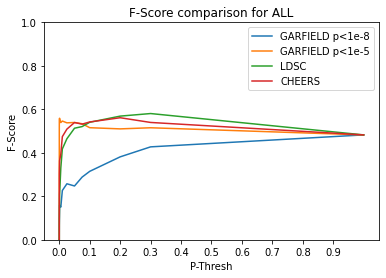

In [55]:
plt.xlabel('P-Thresh')
# Set the y axis label of the current axis.
plt.ylabel('F-Score')
# Set a title of the current axes.
plt.title('F-Score comparison for ALL')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1, 0.1))
plt.plot(G8_metrics_table['P_thresh'], G8_metrics_table['F_score'], label="GARFIELD p<1e-8")
plt.plot(G5_metrics_table['P_thresh'], G5_metrics_table['F_score'], label="GARFIELD p<1e-5")
plt.plot(LDSC_metrics_table['P_thresh'], LDSC_metrics_table['F_score'], label="LDSC")
plt.plot(CHEERS_metrics_table['P_thresh'], CHEERS_metrics_table['F_score'], label="CHEERS")
plt.legend()
plt.show()

In [57]:
def Calc_True_rate(true_n, all_n):
    out_rate=0
    if(all_n > 0):
        return(true_n/all_n)
    else:
        return(0)

def Add_ROC_stats(metric_table):
    metric_table['TPR']=metric_table.apply(lambda x: Calc_True_rate(x['TP'], x['P']), axis=1)
    metric_table['FPR']=metric_table.apply(lambda x: Calc_True_rate(x['FP'], x['N']), axis=1)
    return(metric_table)

G5_metrics_table=Add_ROC_stats(G5_metrics_table)
G8_metrics_table=Add_ROC_stats(G8_metrics_table)
LDSC_metrics_table=Add_ROC_stats(LDSC_metrics_table)
CHEERS_metrics_table=Add_ROC_stats(CHEERS_metrics_table)



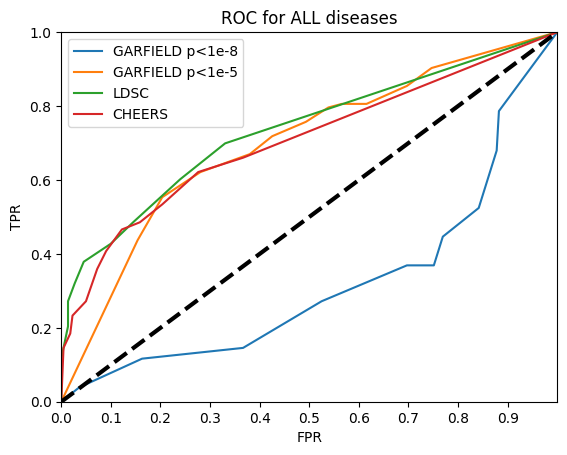

In [95]:
    plt.xlabel('FPR')
    # Set the y axis label of the current axis.
    plt.ylabel('TPR')
    # Set a title of the current axes.
    plt.title('ROC for ALL diseases')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1, 0.1))
    plt.plot(G8_metrics_table['FPR'], G8_metrics_table['TPR'], label="GARFIELD p<1e-8")
    plt.plot(G5_metrics_table['FPR'], G5_metrics_table['TPR'],label="GARFIELD p<1e-5")
    plt.plot(LDSC_metrics_table['FPR'], LDSC_metrics_table['TPR'], label="LDSC")
    plt.plot(CHEERS_metrics_table['FPR'], CHEERS_metrics_table['TPR'], label="CHEERS")

    xpoints=ypoints=plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

    plt.legend()
    plt.show()

In [59]:
G8_metrics_table


,P_thresh,P,TP,N,FP,FN,TN,F_score,TPR,FPR
0,1.00000,103,103,221,221,0,0,0.482436,1.000000,1.000000
1,0.30000,103,81,221,195,22,26,0.427441,0.786408,0.882353
2,0.20000,103,70,221,194,33,27,0.381471,0.679612,0.877828
3,0.10000,103,54,221,186,49,35,0.314869,0.524272,0.841629
4,0.07500,103,46,221,170,57,51,0.288401,0.446602,0.769231
5,0.05000,103,38,221,166,65,55,0.247557,0.368932,0.751131
6,0.02500,103,38,221,154,65,67,0.257627,0.368932,0.696833
7,0.01000,103,28,221,116,75,105,0.226721,0.271845,0.524887
8,0.00500,103,15,221,81,88,140,0.150754,0.145631,0.366516
9,0.00100,103,12,221,36,91,185,0.158940,0.116505,0.162896


In [12]:
import pandas as pd

toploci=pd.read_parquet("~/Downloads/v2d_210922_toploci.parquet")
studies=pd.read_parquet("~/Downloads/v2d_210922_studies.parquet")

Updated_gwascat=pd.read_csv("~/Downloads/gwas_catalog_v1.0.2-studies_r2021-10-22.tsv", sep="\t")
Updated_ancestry=pd.read_csv("~/Downloads/gwas_catalog-ancestry_r2021-10-22.tsv", sep="\t")

Missing_study_entries=toploci.loc[~toploci["study_id"].isin(studies["study_id"])]["study_id"].unique()

new_studies=pd.read_parquet("~/Downloads/studies.parquet")

Missing_gwascat=Updated_gwascat.loc[Updated_gwascat["STUDY ACCESSION"].isin(Missing_study_entries)]

In [3]:
import json
Updated_studies=pd.read_json("~/Downloads/gwascat_studies.json", lines=True)

Studies_to_add=Updated_studies.loc[Updated_studies["study_id"].isin(Missing_study_entries)]

In [17]:
new_studies.loc[new_studies["study_id"].isin(Missing_study_entries) ]

,study_id,pmid,pub_date,pub_journal,pub_title,pub_author,trait_reported,trait_efos,ancestry_initial,ancestry_replication,n_initial,n_replication,n_cases,trait_category,num_assoc_loci,has_sumstats
24235,GCST012210,PMID:33657282,2021-03-03,Aging Cell,Integrated genetic analyses revealed novel hum...,Liu X,Longevity,[EFO_0004300],[East Asian=11045],None,11045,NaN,NaN,Temporal measurement,3,False
24236,GCST012211,PMID:33677556,2021-03-03,Eur Heart J,Genome-wide association analysis in dilated ca...,Garnier S,Dilated cardiomyopathy,[EFO_0000407],[European=6980],[European=1547],6980,1547.0,2651.0,Cardiovascular,2,False
24238,GCST012213,PMID:33667223,2021-03-05,PLoS Genet,Genome-wide association meta-analysis identifi...,Lesseur C,Aerodigestive squamous cell cancer (pleiotropy),[EFO_0004284],[European=75848],None,75848,NaN,13887.0,Disease,21,False
24239,GCST012214,PMID:33654092,2021-03-03,Transl Psychiatry,Ethnic and trans-ethnic genome-wide associatio...,Shigemizu D,Alzheimer's disease,[EFO_0000249],"[European=63926, East Asian=8036]",[East Asian=3662],71962,3662.0,25944.0,Nervous system,1,False
24240,GCST012215,PMID:33654092,2021-03-03,Transl Psychiatry,Ethnic and trans-ethnic genome-wide associatio...,Shigemizu D,Alzheimer's disease,[EFO_0000249],[East Asian=8036],[East Asian=3662],8036,3662.0,3962.0,Nervous system,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34063,GCST90026593,PMID:33547071,2021-02-05,Sci Adv,A GWAS in Latin Americans identifies novel fac...,Bonfante B,Facial morphology (brow ridge protrusion 3),[EFO_0007841],[Hispanic or Latin American=6169],None,6169,NaN,NaN,Facial morphology measurement,2,False
34065,GCST90026595,PMID:33547071,2021-02-05,Sci Adv,A GWAS in Latin Americans identifies novel fac...,Bonfante B,Facial morphology (lower face flatness),[EFO_0010948],[Hispanic or Latin American=6169],None,6169,NaN,NaN,Facial morphology measurement,1,False
34149,GCST90027233,PMID:34380431,2021-08-11,J Headache Pain,Identifying genetic variants for age of migrai...,Tsai CK,Migraine (age at onset),"[EFO_0004847, EFO_0003821]",[East Asian=715],None,715,NaN,NaN,Cardiovascular,1,False
34150,GCST90027234,PMID:34380431,2021-08-11,J Headache Pain,Identifying genetic variants for age of migrai...,Tsai CK,Migraine with aura (age at onset),"[EFO_0004847, EFO_0005295]",[East Asian=167],None,167,NaN,NaN,Cardiovascular,3,False


In [20]:
new_studies.loc[new_studies["trait_category"].str.contains("measurement")]

,study_id,pmid,pub_date,pub_journal,pub_title,pub_author,trait_reported,trait_efos,ancestry_initial,ancestry_replication,n_initial,n_replication,n_cases,trait_category,num_assoc_loci,has_sumstats
2304,FINNGEN_R5_O15_DELIVERY,,2021-5-11,,,FINNGEN_R5,Delivery,[EFO_0006922],[European=123579],[],123579,0.0,63978.0,Delivery measurement,2,True
2392,FINNGEN_R5_P16_DISORD_RELATED_GESTATION_LOW_BI...,,2021-5-11,,,FINNGEN_R5,"""Disorders related to short gestation and low ...","[EFO_0003965, EFO_0003917]",[European=218748],[],218748,0.0,258.0,Anthropometric measurement,0,True
2535,FINNGEN_R5_R18_ILL_D_UNKNO_CAUSES_MORTA,,2021-5-11,,,FINNGEN_R5,Ill-defined and unknown causes of mortality,"[EFO_0004352, EFO_0009434]",[European=218792],[],218792,0.0,443.0,Population measurement,1,True
2826,FINNGEN_R5_VWXY20_BLOOD_ALCOHOL_ALCOHOL_INTOX_...,,2021-5-11,,,FINNGEN_R5,Blood alcohol or alcohol intoxication level,[EFO_0007878],[European=218590],[],218590,0.0,251.0,Alcohol consumption measurement,0,True
2828,FINNGEN_R5_VWXY20_EVIDE_ALCOHOL_INVOLVM_DETERM...,,2021-5-11,,,FINNGEN_R5,Evidence of alcohol involvement determined by ...,[EFO_0007878],[European=218131],[],218131,0.0,137.0,Alcohol consumption measurement,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36531,NEALE2_6179_4,,2018-08-01,,,UKB Neale v2,Zinc | mineral and other dietary supplements,[EFO_0009116],[European=360016],[],360016,0.0,14402.0,Environmental exposure measurement,1,True
36532,NEALE2_6179_5,,2018-08-01,,,UKB Neale v2,Iron | mineral and other dietary supplements,[EFO_0009116],[European=360016],[],360016,0.0,10695.0,Environmental exposure measurement,0,True
36533,NEALE2_6179_6,,2018-08-01,,,UKB Neale v2,Selenium | mineral and other dietary supplements,[EFO_0009116],[European=360016],[],360016,0.0,8518.0,Environmental exposure measurement,0,True
36542,NEALE2_78_raw,,2018-08-01,,,UKB Neale v2,"Heel bone mineral density (bmd) t-score, autom...",[EFO_0009270],[European=206589],[],206589,0.0,NaN,Bone measurement,365,True


In [21]:
Updated_study_table=pd.concat([studies, new_studies.loc[new_studies["study_id"].isin(Missing_study_entries)].reset_index(drop=True)]).reset_index(drop=True)


In [27]:
Additional_row=pd.Series(["GCST010653", "PMID:32769997",
                            "2020-08-07", "Nat Commun", "GWAS of thyroid stimulating hormone highlights pleiotropic effects and inverse association with thyroid cancer.", 
                            "Zhou W", "Thyroid stimulating hormone levels", 
                            ['EFO_0004748'], "[European=119715]", "None", "119715", "", "NaN", "Hormone measurement", "99", "False"])
Additional_row2=pd.Series(
                            ["GCST010729", "PMID:32335043",
                            "2020-04-22", "J Acad Nutr Diet", "Alcohol, Carbohydrate, and Calcium Intakes and Smoking Interactions with APOA5 rs662799 and rs2266788 were Associated with Elevated Plasma Triglyceride Concentrations in a Cross-Sectional Study of Korean Adults.", 
                            "Park S", "Triglyceride levels", 
                            ['EFO_0004530'], "[East Asian=28438]", "None", "28438", "", "NaN", "Lipid measurement", "1", "False"])
row_df=pd.DataFrame([Additional_row])
row_df=row_df.set_axis(list(Updated_study_table.columns.values), axis=1, inplace=False)
new_study_table=pd.concat([Updated_study_table, row_df], ignore_index=True)

row_df=pd.DataFrame([Additional_row2])
row_df=row_df.set_axis(list(Updated_study_table.columns.values), axis=1, inplace=False)
new_study_table2=pd.concat([new_study_table, row_df], ignore_index=True)


In [30]:
new_study_table2

,study_id,pmid,pub_date,pub_journal,pub_title,pub_author,trait_reported,trait_efos,ancestry_initial,ancestry_replication,n_initial,n_replication,n_cases,trait_category,num_assoc_loci,has_sumstats
0,FINNGEN_R5_AB1_AMOEBIASIS,,2021-5-11,,,FINNGEN_R5,Amoebiasis,[EFO_0007144],[European=197385],[],197385,0.0,87.0,Disease,0,True
1,FINNGEN_R5_AB1_ANOGENITAL_HERPES_SIMPLEX,,2021-5-11,,,FINNGEN_R5,Anogenital herpesviral [herpes simplex] infection,[EFO_0007282],[European=213843],[],213843,0.0,891.0,Disease of genitourinary system,0,True
2,FINNGEN_R5_AB1_ARTHROPOD,,2021-5-11,,,FINNGEN_R5,Arthropod-borne viral fevers and viral haemorr...,"[EFO_0000763, MONDO_0018087]",[European=218792],[],218792,0.0,1450.0,Disease,0,True
3,FINNGEN_R5_AB1_ASPERGILLOSIS,,2021-5-11,,,FINNGEN_R5,Aspergillosis,[EFO_0007157],[European=214903],[],214903,0.0,87.0,Disease,0,True
4,FINNGEN_R5_AB1_ATYPICAL_CNS_VIRUS,,2021-5-11,,,FINNGEN_R5,Atypical virus infections of central nervous s...,[MONDO_0024318],[European=217783],[],217783,0.0,146.0,Uncategorised,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36390,GCST90027233,PMID:34380431,2021-08-11,J Headache Pain,Identifying genetic variants for age of migrai...,Tsai CK,Migraine (age at onset),"[EFO_0004847, EFO_0003821]",[East Asian=715],None,715,NaN,NaN,Cardiovascular,1,False
36391,GCST90027234,PMID:34380431,2021-08-11,J Headache Pain,Identifying genetic variants for age of migrai...,Tsai CK,Migraine with aura (age at onset),"[EFO_0004847, EFO_0005295]",[East Asian=167],None,167,NaN,NaN,Cardiovascular,3,False
36392,GCST90027235,PMID:34380431,2021-08-11,J Headache Pain,Identifying genetic variants for age of migrai...,Tsai CK,Migraine without aura (age at onset),"[EFO_0004847, EFO_0005296]",[East Asian=548],None,548,NaN,NaN,Cardiovascular,1,False
36393,GCST010653,PMID:32769997,2020-08-07,Nat Commun,GWAS of thyroid stimulating hormone highlights...,Zhou W,Thyroid stimulating hormone levels,[EFO_0004748],[European=119715],None,119715,,NaN,Hormone measurement,99,False


In [29]:
new_study_table2.to_parquet("~/Downloads/Updated_studies.parquet")

ArrowInvalid: ('cannot mix list and non-list, non-null values', 'Conversion failed for column ancestry_initial with type object')

In [10]:
for i in Missing_study_entries:
    if (~Studies_to_add["study_id"].str.contains(i).any()):
        print(i)

GCST010653
GCST010729


In [19]:
new_studies.columns

Index(['study_id', 'pmid', 'pub_date', 'pub_journal', 'pub_title',
       'pub_author', 'trait_reported', 'trait_efos', 'ancestry_initial',
       'ancestry_replication', 'n_initial', 'n_replication', 'n_cases',
       'trait_category', 'num_assoc_loci', 'has_sumstats'],
      dtype='object')

In [7]:
studies

,study_id,pmid,pub_date,pub_journal,pub_title,pub_author,trait_reported,trait_efos,ancestry_initial,ancestry_replication,n_initial,n_replication,n_cases,trait_category,num_assoc_loci,has_sumstats
0,FINNGEN_R5_AB1_AMOEBIASIS,,2021-5-11,,,FINNGEN_R5,Amoebiasis,[EFO_0007144],[European=197385],[],197385,0.0,87.0,Disease,0,True
1,FINNGEN_R5_AB1_ANOGENITAL_HERPES_SIMPLEX,,2021-5-11,,,FINNGEN_R5,Anogenital herpesviral [herpes simplex] infection,[EFO_0007282],[European=213843],[],213843,0.0,891.0,Disease of genitourinary system,0,True
2,FINNGEN_R5_AB1_ARTHROPOD,,2021-5-11,,,FINNGEN_R5,Arthropod-borne viral fevers and viral haemorr...,"[EFO_0000763, MONDO_0018087]",[European=218792],[],218792,0.0,1450.0,Disease,0,True
3,FINNGEN_R5_AB1_ASPERGILLOSIS,,2021-5-11,,,FINNGEN_R5,Aspergillosis,[EFO_0007157],[European=214903],[],214903,0.0,87.0,Disease,0,True
4,FINNGEN_R5_AB1_ATYPICAL_CNS_VIRUS,,2021-5-11,,,FINNGEN_R5,Atypical virus infections of central nervous s...,[MONDO_0024318],[European=217783],[],217783,0.0,146.0,Uncategorised,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36219,SAIGE_988,,2018-10-24,,,UKB SAIGE,Toxic effect of noxious substances eaten as food,[EFO_0008546],[European=408481],[],408481,0.0,114.0,Disease,0,True
36220,SAIGE_989,,2018-10-24,,,UKB SAIGE,"Toxic effect of other substances, chiefly nonm...",[EFO_0008546],[European=408425],[],408425,0.0,58.0,Disease,0,True
36221,SAIGE_990,,2018-10-24,,,UKB SAIGE,Effects radiation nos,[EFO_0009658],[European=406425],[],406425,0.0,3130.0,Disease,0,True
36222,SAIGE_994,,2018-10-24,,,UKB SAIGE,Sepsis and sirs,[HP_0100806],[European=408961],[],408961,0.0,2811.0,Uncategorised,0,True


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Ed Mountjoy
#

import sys
import os
import argparse
import pandas as pd
from pprint import pprint
from collections import OrderedDict
import hashlib
from numpy import nan
from functools import reduce
import re

def main():

    # Parse args
    args = parse_args()

    #
    # Load study table from association table ----------------------------------
    #

    # We need to join GWAS Catalog's study table with the top loci
    # (association) table in order to get subphenotype in the
    # "P-VALUE (TEXT)" field.
    # We can't use the top loci table by itself as this would only include
    # studies with > 0 associations (may not be valid for phewas studies).

    # Load GWAS Catalog's study table
    cols_to_keep = ['STUDY ACCESSION', 'PUBMEDID', 'DATE', 'JOURNAL', 'STUDY', 'INITIAL SAMPLE SIZE', 'FIRST AUTHOR', 'DISEASE/TRAIT', 'MAPPED_TRAIT_URI']
    
    # Load GWAS Catalog's study table
    gwascat_studies = pd.read_csv(args.in_gwascat_study, sep='\t', header=0,low_memory=False).loc[:, cols_to_keep]

    # Load study table from top loci table
    toploci_studies = (pd.read_csv(args.in_toploci, sep='\t', header=0, low_memory=False).loc[:, cols_to_keep + ['P-VALUE (TEXT)']].drop_duplicates())

    # Groupby will drop null 'P-VALUE (TEXT)' fields
    toploci_studies['P-VALUE (TEXT)'] = toploci_studies['P-VALUE (TEXT)'].fillna('')
     
    # Merge gwascat_studies with toploci_studies
    studies = pd.merge(gwascat_studies, toploci_studies, on=cols_to_keep, how='outer').fillna('')

    # Sometimes GWAS Catalog "DISEASE/TRAIT" information does not match between
    # their study and association table.
    # HACK: deduplicate by study_id and pval text
    studies = studies.drop_duplicates(subset=['STUDY ACCESSION', 'P-VALUE (TEXT)'])

    # # DEBUG
    # studies.loc[studies['STUDY ACCESSION'] == 'GCST009066', :].to_csv('tmp/studies_GCST009066.tsv', sep='\t', index=None)
    # studies.to_csv('tmp/studies.tsv', sep='\t', index=None)
    # toploci_studies.to_csv('tmp/toploci_studies.tsv', sep='\t', index=None)
    # print(gwascat_studies.loc[gwascat_studies['STUDY ACCESSION'] == 'GCST009066', :].shape)
    # print(toploci_studies.loc[toploci_studies['STUDY ACCESSION'] == 'GCST009066', :].shape)
    # print(studies.loc[studies['STUDY ACCESSION'] == 'GCST009066', :].shape)
    # sys.exit()

    # Remove Sun et al pQTL study
    studies = studies.loc[studies['STUDY ACCESSION'] != 'GCST005806', :]
    # Remove Huang et al IBD study (GWAS Catalog should not have curated this)
    studies = studies.loc[studies['STUDY ACCESSION'] != 'GCST005837', :]

    #
    # Extract n info from 'INITIAL SAMPLE SIZE' -------------------------------
    #

    # Extract info
    n_counts = studies['INITIAL SAMPLE SIZE'].apply(extract_sample_sizes)
    # studies['n_initial'] = n_counts.apply(lambda x: x[0])
    studies['n_cases'] = n_counts.apply(lambda x: x[1])
    
    # Drop 'INITIAL SAMPLE SIZE'
    studies = studies.drop('INITIAL SAMPLE SIZE', axis=1)
    
    #
    # Group EFO codes together -------------------------------------------------
    #

    # EFOs can be different for the ('STUDY ACCESSION', 'P-VALUE (TEXT)') pairs.
    # They must be grouped.
    studies['MAPPED_TRAIT_URI'] = studies['MAPPED_TRAIT_URI'].str.split(', ')
    group_cols = ['STUDY ACCESSION', 'PUBMEDID', 'DATE', 'JOURNAL', 'STUDY', 'FIRST AUTHOR', 'DISEASE/TRAIT', 'P-VALUE (TEXT)', 'n_cases']
    studies = (studies.groupby(group_cols).MAPPED_TRAIT_URI.agg(trait_efos=sum).reset_index())

    # Clean and convert EFO list back to string, otherwise pandas can't hash it
    studies['trait_efos'] = studies['trait_efos'].apply(clean_efo)

    #
    # Create new trait name and study IDs --------------------------------------
    #

    # Create new trait name from 'DISEASE/TRAIT' and 'P-VALUE (TEXT)'
    studies['trait_combined'] = (studies.loc[:, ['DISEASE/TRAIT', 'P-VALUE (TEXT)']].apply(make_new_trait_name, axis=1))

    # Sort and deduplicate
    studies = (studies.sort_values(by=['STUDY ACCESSION', 'trait_combined']).drop_duplicates())

    # Create new study_ids from 'STUDY ACCESSION' and 'trait_combined'
    studies['study_id'] = make_new_study_id(studies.loc[:, ['STUDY ACCESSION', 'trait_combined']])

    # Output a study ID lookup table for use elsewhere.
    (
        studies.loc[:, ['STUDY ACCESSION', 'P-VALUE (TEXT)', 'study_id']]
               .to_csv(args.out_id_lut, sep='\t', index=None)
    )
    # studies.to_csv('studies.test.tsv', sep='\t', index=None)

    # Drop 'P-VALUE (TEXT)' and deduplicate
    studies = (studies.drop('P-VALUE (TEXT)', axis=1).drop_duplicates())

    # Assert that there are no duplicated IDs. Very important as GWAS Catalog
    # does not perform checks on 'P-VALUE (TEXT)' or 'MAPPED_TRAIT_URI'
    # which can introduce errors
    assert (studies.study_id.value_counts() == 1).all(), \
        'Error: There are duplicated study IDs'

    #
    # Load and merge ancestry information --------------------------------------
    #

    # Load ancestry info
    anc = parse_ancestry_info(args.in_ancestries)

    # Merge study and ancestry info
    merged = pd.merge(studies, anc, on='STUDY ACCESSION', how='left')

    # merged['trait_code'] = [make_hash_trait(val) for val in merged['DISEASE/TRAIT']]

    #
    # Process ------------------------------------------------------------------
    #

    # Keep required cols
    cols = OrderedDict([
        # ['STUDY ACCESSION', 'study_accession'],
        ['study_id', 'study_id'],
        ['PUBMEDID', 'pmid'],
        ['DATE', 'pub_date'],
        ['JOURNAL', 'pub_journal'],
        ['STUDY', 'pub_title'],
        ['FIRST AUTHOR', 'pub_author'],
        ['trait_combined', 'trait_reported'],
        ['trait_efos', 'trait_efos'],
        # ['trait_code', 'trait_code'],
        # ['MAPPED_TRAIT', 'trait_mapped'],
        ['ancestry_initial', 'ancestry_initial'],
        ['ancestry_replication', 'ancestry_replication'],
        ['n_initial', 'n_initial'],
        ['n_cases', 'n_cases'],
        ['n_replication', 'n_replication']
    ])
    df = merged.rename(columns=cols).loc[:, cols.values()]

    # Add prefix to PMIDs
    df['pmid'] = 'PMID:' + df['pmid'].astype(str)

    # Set sample size columns to NaN if they are 0
    for colname in ['n_initial', 'n_cases', 'n_replication']:
        df[colname] = df[colname].replace({0: nan})
    
    # Split the efos into a list
    df['trait_efos'] = df['trait_efos'].str.split(';')

    # Remove rows where n_initial == nan, these are old studies and their data is
    # inconsistent with the rest of GWAS Catalog (correspondance w Annalisa Buniello)
    df = df.loc[~pd.isnull(df.n_initial), :]

    # Write
    df.to_json(args.outf, orient='records', lines=True)


def extract_sample_sizes(s):
    ''' Extracts sample size info from GWAS Catalog
        "INITIAL SAMPLE SIZE" field
    Returns:
        total N, N cases
    '''
    n_cases = 0
    n_controls = 0
    n_quant = 0
    for part in s.split(', '):
        # Extract sample size
        mtch = re.search('([0-9,]+)', part)
        if mtch:
            n = int(mtch.group(1).replace(',', ''))
            # Add to correct counter
            if 'cases' in part:
                n_cases += n
            elif 'controls' in part:
                n_controls += n
            else:
                n_quant += n
    
    # Return n_total and n_cases
    if n_quant > 0:
        return n_quant, 0
    else:
        return n_cases + n_controls, n_cases

def clean_efo(l, sep=';'):
    ''' Takes a list of EFO URIs, cleans them and returns a string
    Params:
        l (list)
    Returns:
        str
    '''
    try:
        return sep.join(set([v.split('/')[-1] for v in l]))
    except TypeError:
        return nan

def make_new_study_id(df):
    ''' Creates a unique study ID from the origin STUDY ACCESSION for each
        new trait
    Params:
        df (pd.df): dataframe with 2 columns: Study accession, trait name
    Returns:
        list of strs
    '''
    cache = {}
    new_ids = []
    for accession, trait in df.values.tolist():

        # Add missing accession to cache
        if not accession in cache:
            cache[accession] = {'counter': 0}

        # Add missing trait to cache
        if not trait in cache[accession]:
            cache[accession]['counter'] += 1
            cache[accession][trait] = cache[accession]['counter']

        # Create new id. only add suffix if counter > 1
        if cache[accession][trait] == 1:
            new_id = accession
        elif cache[accession][trait] > 1:
            new_id = '{0}_{1}'.format(accession, cache[accession][trait])
        else:
            sys.exit('Error: counter < 1')
        new_ids.append(new_id)

    return new_ids

def make_new_trait_name(row):
    ''' Takes 'DISEASE/TRAIT' and 'P-VALUE (TEXT)' to combine them into a
        single string
    Params:
        row (pd.Series): A single row from pd.df.apply(axis=1)
    Returns:
        string
    '''
    if row['P-VALUE (TEXT)'] == '':
        return row['DISEASE/TRAIT']
    else:
        return '{0} [{1}]'.format(
            row['DISEASE/TRAIT'],
            row['P-VALUE (TEXT)'].strip('()') )

# def make_hash_trait(traitlabel):
#     '''creates an id for each GWAS trait with
#     low probability of collision
#     '''
#     hasher = hashlib.md5(traitlabel.encode('utf-8').lower())
#     # truncating it in half gives 64 bit, which for ~10000 traits makes the collision probability < 1e-7
#     return 'GT_' + hasher.hexdigest()[0:16]

def parse_ancestry_info(inf):
    ''' Parse the GWAS Catalog ancestry info file to get 1 row per study
    Args:
        inf (str): GWAS Catalog ancestry file
    Returns:
        pandas df
    '''
    anc_dict = {}
    df = pd.read_csv(inf, sep='\t', header=0, index_col=False)
    grouped = df.groupby(['STUDY ACCESSION', 'STAGE'])
    for name, group in grouped:
        # Add study id to output dict
        study_id, stage = name
        if not study_id in anc_dict:
            anc_dict[study_id] = {}
        # Make N
        key = 'n_{0}'.format(stage)
        value = int(group['NUMBER OF INDIVDUALS'].sum())
        anc_dict[study_id][key] = str(value)
        # Make ancestry string
        key = 'ancestry_{0}'.format(stage)
        values = []
        for cat, n in zip(group['BROAD ANCESTRAL CATEGORY'], group['NUMBER OF INDIVDUALS']):
            # Fix problem with "Greater Middle Eastern (Middle Eastern, North African or Persian)"
            cat = cat.replace(
                'Greater Middle Eastern (Middle Eastern, North African or Persian)',
                'Greater Middle Eastern (Middle Eastern / North African / Persian)'
            )
            try:
                n = int(n)
            except ValueError:
                n = 0
            values.append('{0}={1}'.format(cat, n))
        value = ';'.join(values)
        anc_dict[study_id][key] = value

    # Make df
    anc_df = pd.DataFrame.from_dict(anc_dict, orient='index')
    anc_df.insert(0, 'STUDY ACCESSION', anc_df.index)

    return anc_df

def parse_args():
    """ Load command line args """
    parser = argparse.ArgumentParser()
    parser.add_argument('--in_gwascat_study', metavar="<str>", type=str, required=True)
    parser.add_argument('--in_toploci', metavar="<str>", type=str, required=True)
    parser.add_argument('--in_ancestries', metavar="<str>", type=str, required=True)
    parser.add_argument('--outf', metavar="<str>", help=("Output"), type=str, required=True)
    parser.add_argument('--out_id_lut', metavar="<str>", help=("Output study ID lut file"), type=str, required=True)
    args = parser.parse_args()
    return args

if __name__ == '__main__':

    main()
